In [ ]:
!pip install yfinance

In [ ]:
# ARIMA
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import statsmodels.api as sm
import warnings
import itertools
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:


def optimal_para_selection(series, i):
  # Define the p, d and q parameters to take any value between 0 and 2
  p = d = q = range(0, 2)

  # Generate all different combinations of seasonal p, q and q triplets
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

  # Generate all different combinations of p, q and q triplets
  pdq = list(itertools.product(p, d, q))
  warnings.filterwarnings("ignore") # specify to ignore warning messages
  
  aic = 1000000000
  param_optimal = 0
  param_seasonal_optimal = 0
  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
              mod = sm.tsa.statespace.SARIMAX(series,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

              results = mod.fit()
              if results.aic < aic:
                #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                aic = results.aic
                param_optimal = param
                param_seasonal_optimal = param_seasonal
          except:
              continue
  return (param_optimal, param_seasonal_optimal, aic)



In [ ]:



def evaluate_model(series, param_optimal, param_seasonal_optimal):

  mod = sm.tsa.statespace.SARIMAX(series,
                                order=param_optimal,
                                seasonal_order=param_seasonal_optimal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

  results = mod.fit()
  
  
  return results


In [ ]:

def evaluate_plot(series,results, test_start_day, plot_start_day):

  test_start_day = series[test_start_day-relativedelta(days=+6):test_start_day].index[0].date()
  test_start_day = datetime.strptime(str(test_start_day), '%Y-%m-%d').date()
  pred = results.get_prediction(start=pd.to_datetime(test_start_day), dynamic=False)
  fig=plt.figure(figsize=(15, 15))
  ax = series[plot_start_day:].plot()#label='observed')
  pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
  pred_ci = pred.conf_int()
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)

  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
  plt.show()
  return ax



In [ ]:


def train_model(series_train, param_optimal, param_seasonal_optimal):
  
  mod = sm.tsa.statespace.SARIMAX(series_train,
                                  order=param_optimal,
                                  seasonal_order=param_seasonal_optimal,
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

  results = mod.fit()

  return results



In [ ]:
def prediction(train_result,i):
  # Get forecast 500 steps ahead in future
  pred_uc = train_result.get_forecast(steps=len(test))

  # Get confidence intervals of forecasts
  pred_ci = pred_uc.conf_int()
  test['pred'+str(i)] = pred_uc.predicted_mean.values
  return test



In [ ]:
def investment_plot_no_actual(i,series_train,numOfETF):
  fig=plt.figure(figsize=(15, 15))
  # ax = test.iloc[:,i].plot(label='actual')
  #print(test.iloc[:,i])
  ax = test.iloc[:,i+numOfETF].plot(label='predicted')
  #print(test.iloc[:,i+14])
  series_train.plot() # ax=ax,label="historical
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
  return ax


In [ ]:
def investment_plot(i,series_train, numOfETF):
  fig=plt.figure(figsize=(15, 15))
  ax = test.iloc[:,i].plot(label='actual')
  #print(test.iloc[:,i])
  test.iloc[:,i+numOfETF].plot(ax=ax,label='predicted')
  #print(test.iloc[:,i+14])
  series_train.plot()
  ax.set_xlabel('Date')
  ax.set_ylabel('Price')
  plt.legend()
  return ax


In [ ]:
# download data from yahoo finance
tickers = 'SPY XLK IWO VXUS XIC.TO BND SHY VCSH IGOV XBB.TO XSH.TO VHT GLD VNQ'
# data = yf.download(tickers=tickers, start="2012-01-01", end=invest_end_day,interval='1wk')
final_day = datetime.strptime('2020-05-31', '%Y-%m-%d').date()
df = yf.download(tickers=tickers, start="2012-01-01", end=final_day,interval='1wk')['Adj Close'].dropna()
numOfETF = len(df.columns)
 # reduce dataframe to rows, where all asset prices are present
plot_start_day = '2012'
# initialize 
invest_end_day = datetime.strptime("2015-04-01", '%Y-%m-%d').date()

# end_date = datetime.strptime(final_day, '%Y-%m-%d').date()
start_date = invest_end_day
num_months = (final_day.year - start_date.year) * 12 + (final_day.month - start_date.month)
num_of_forcast = math.ceil(num_months/6)

forcast_monthly_return_table = pd.DataFrame()
# print(forcast_monthly_return_table)

[*********************100%***********************]  14 of 14 completed


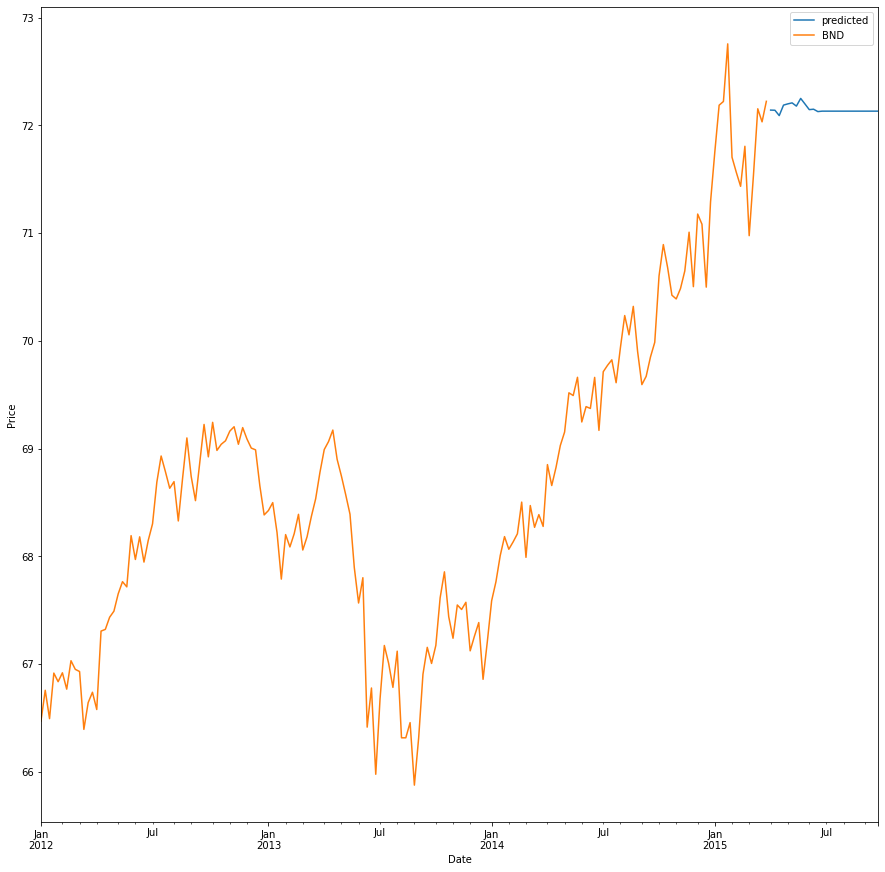

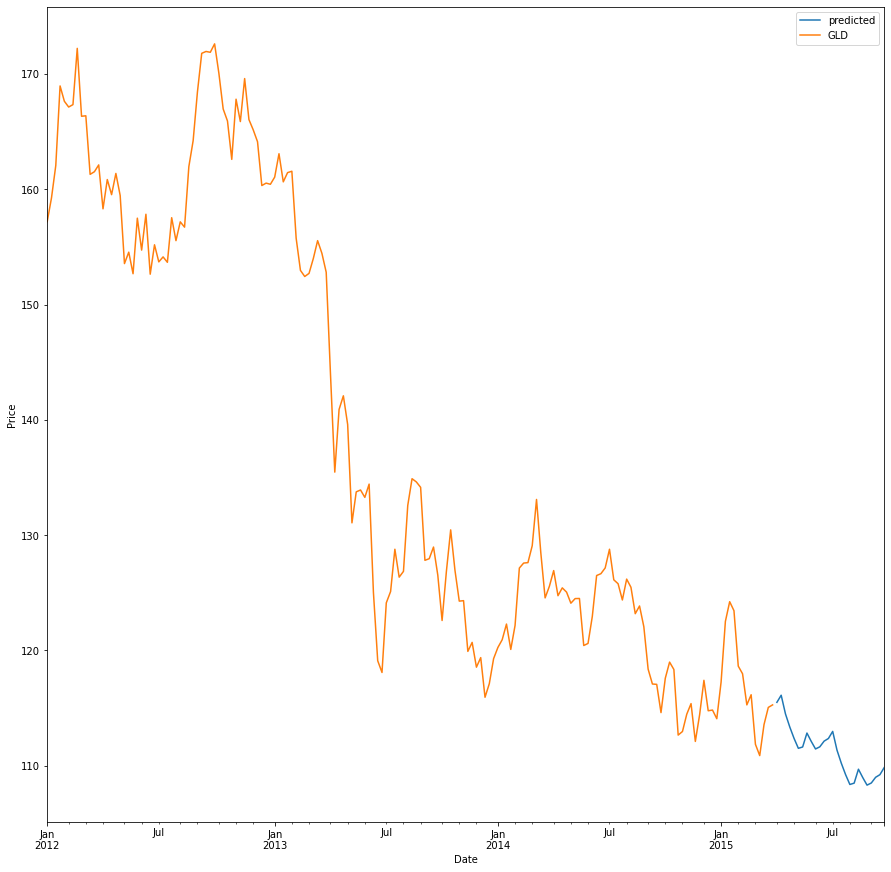

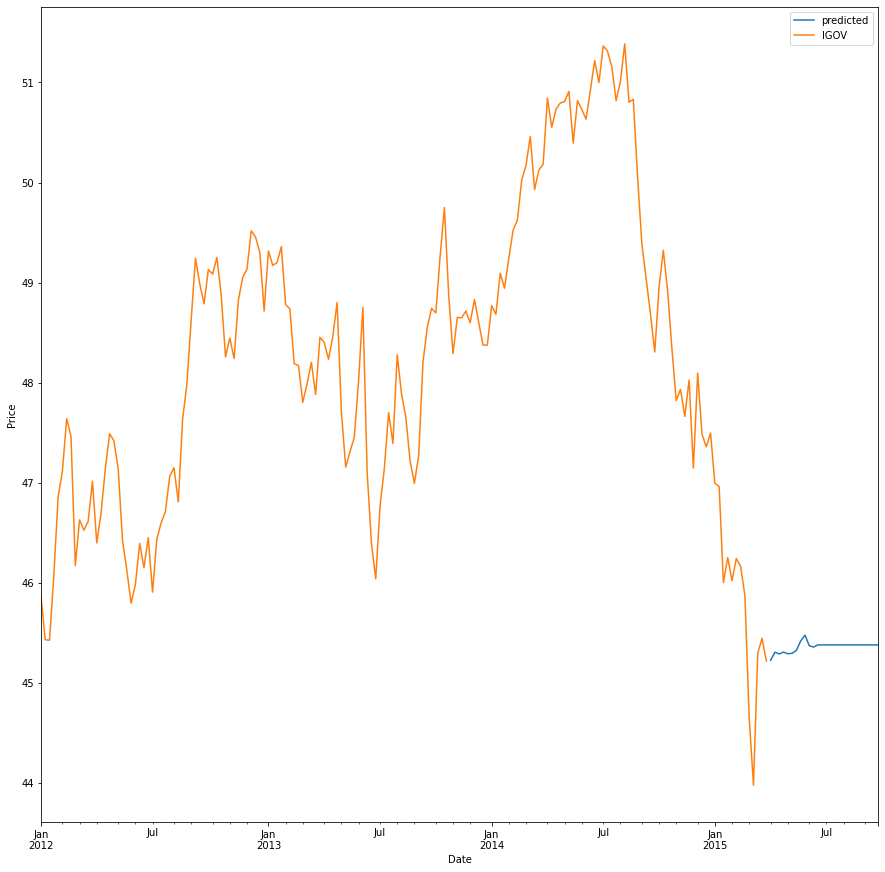

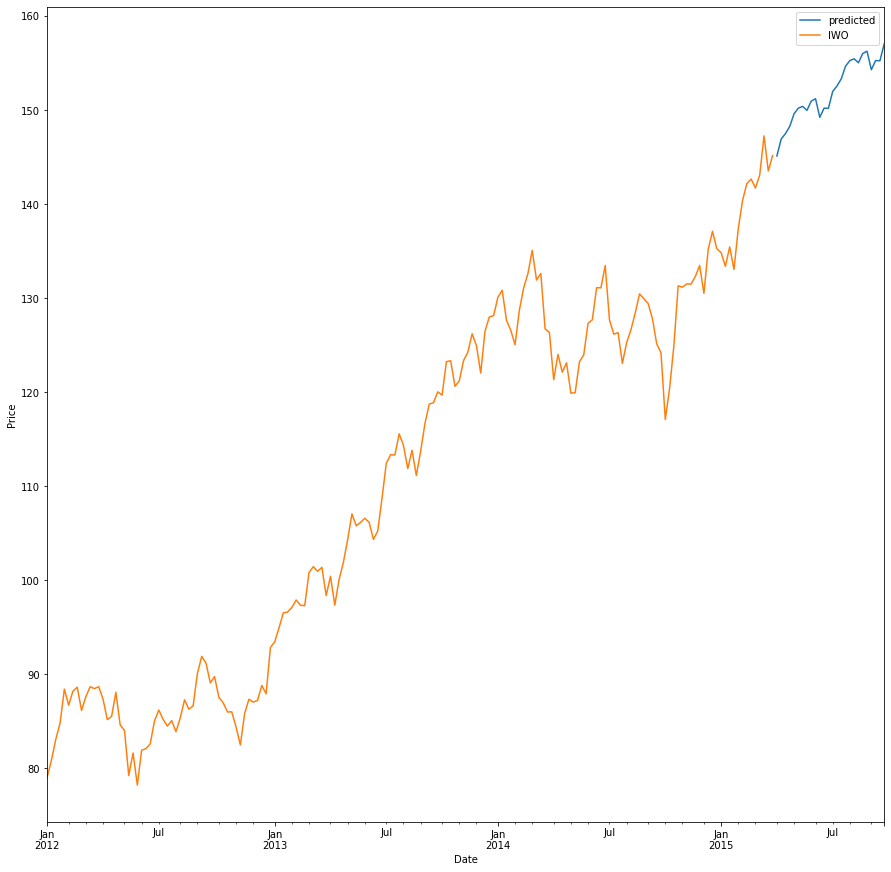

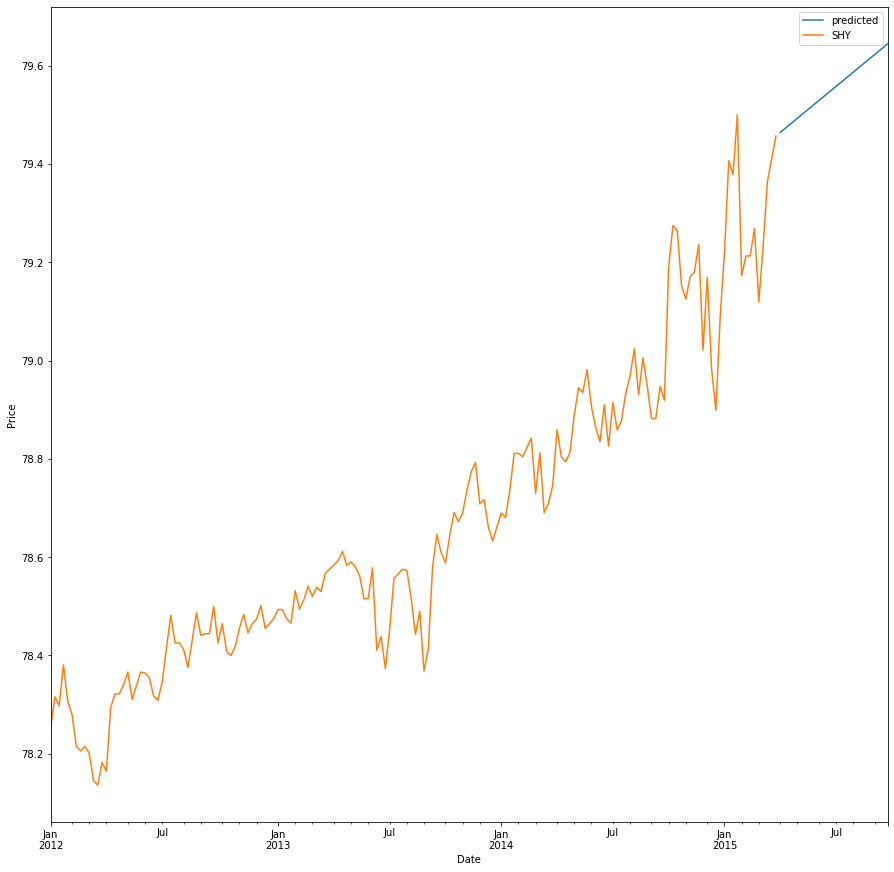

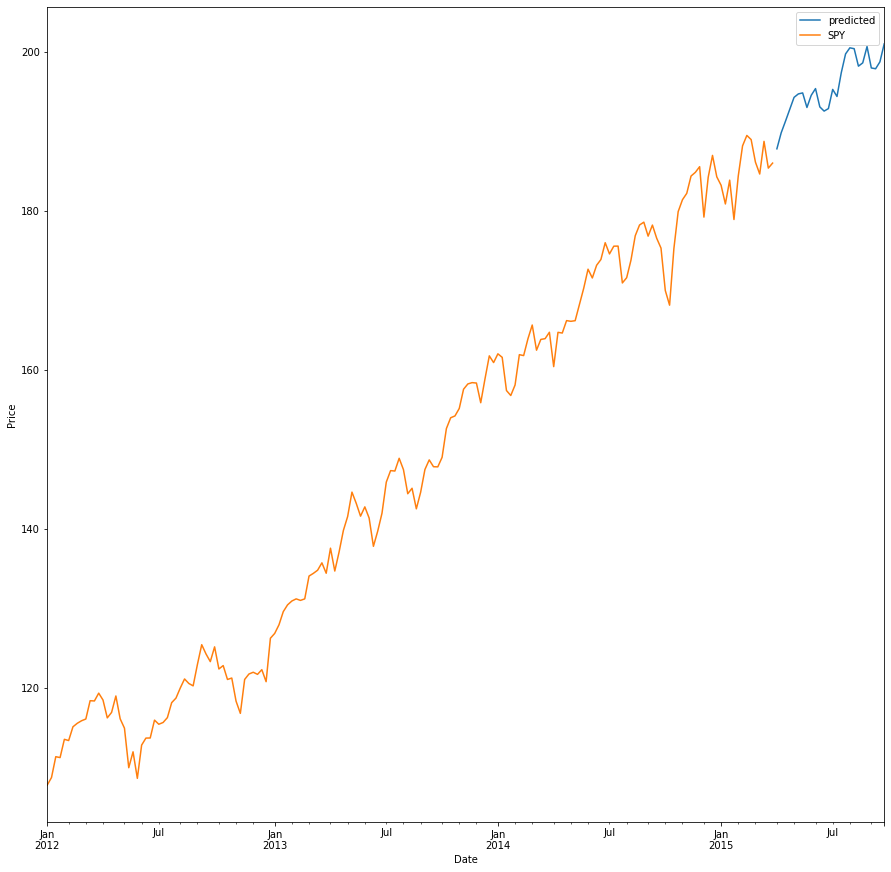

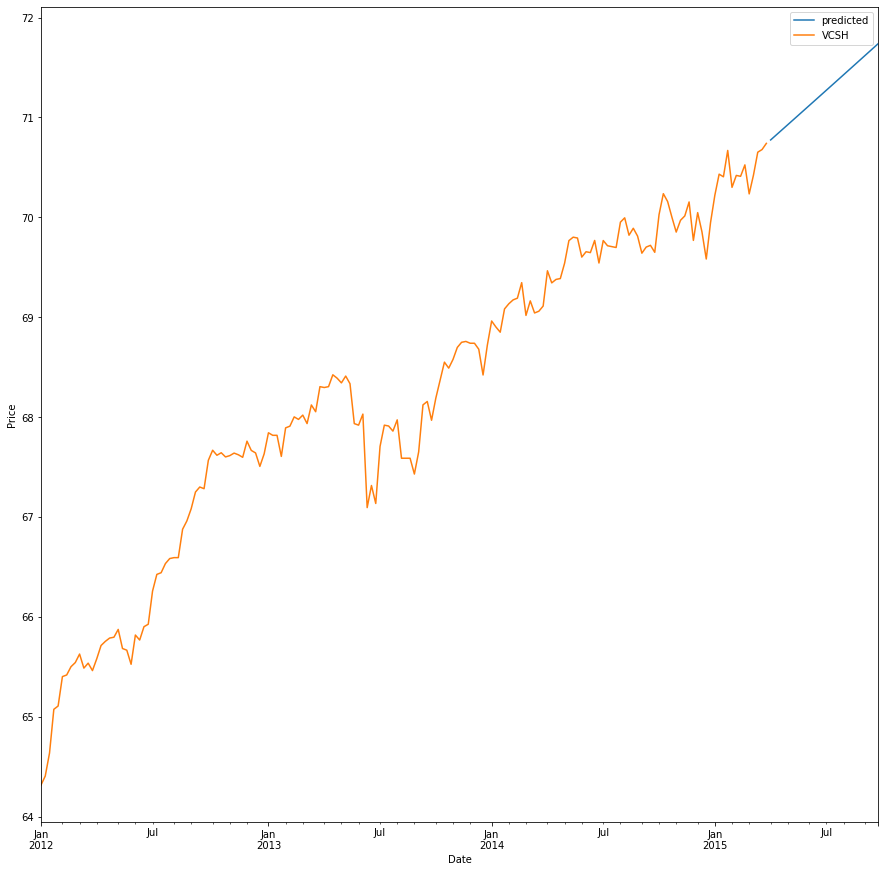

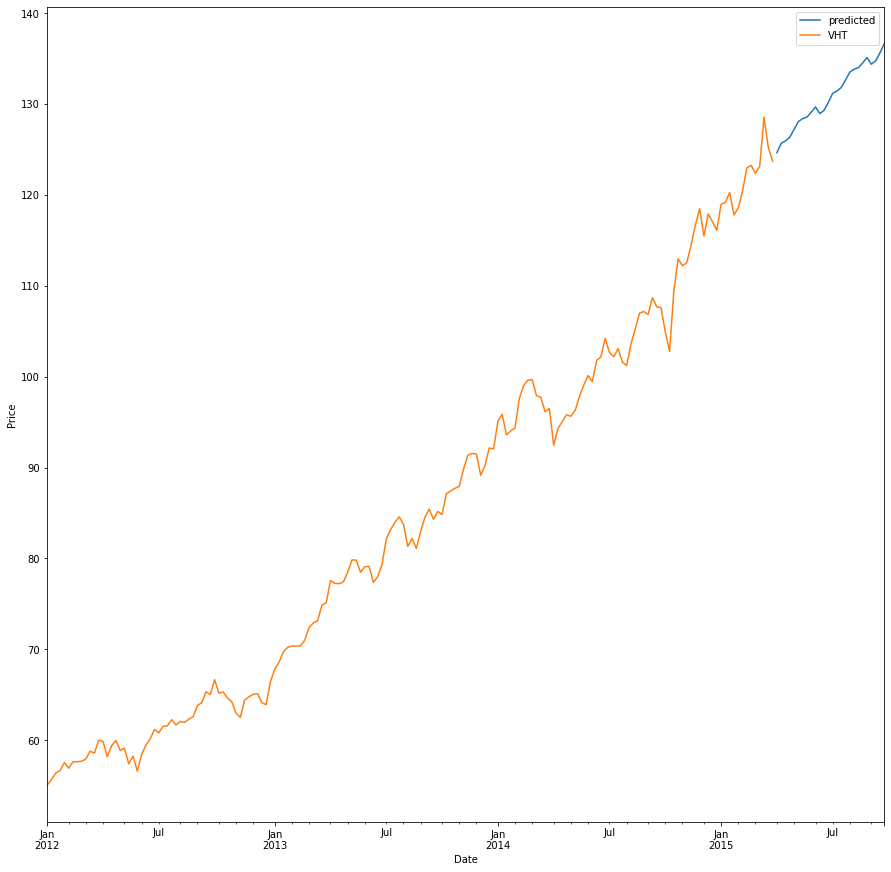

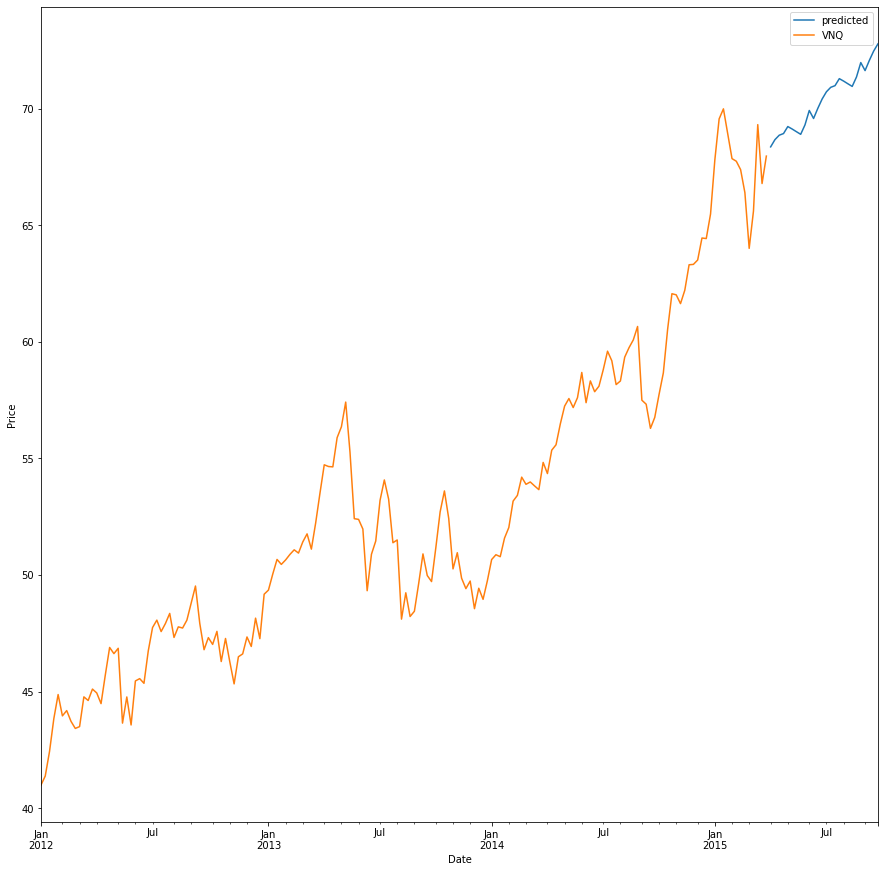

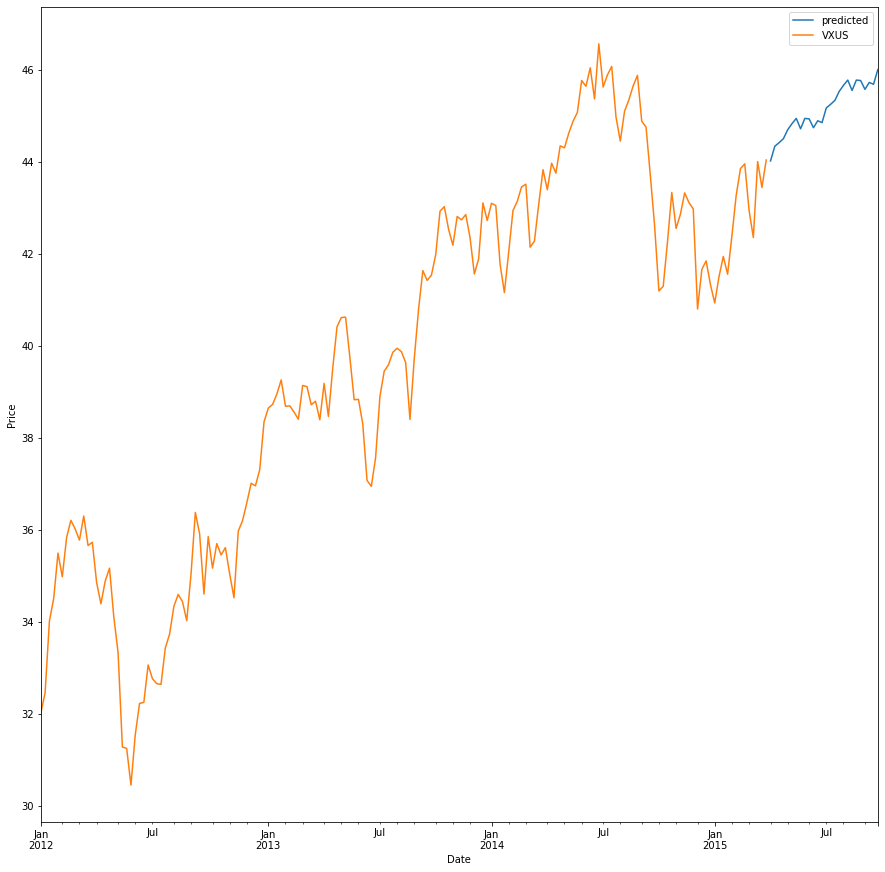

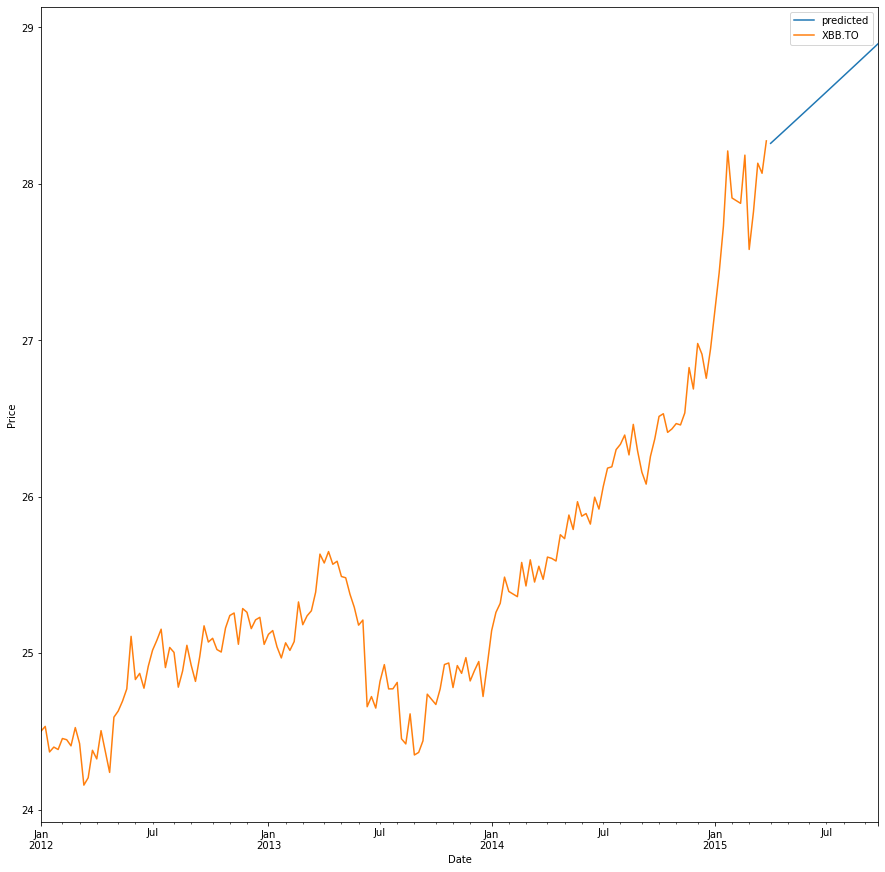

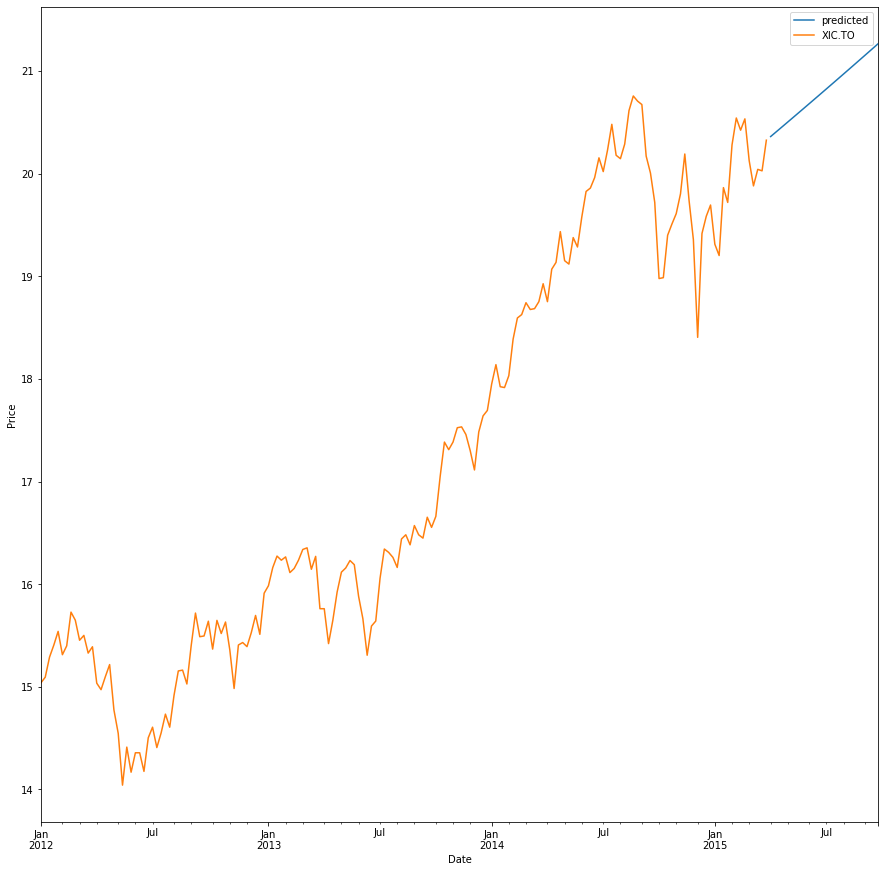

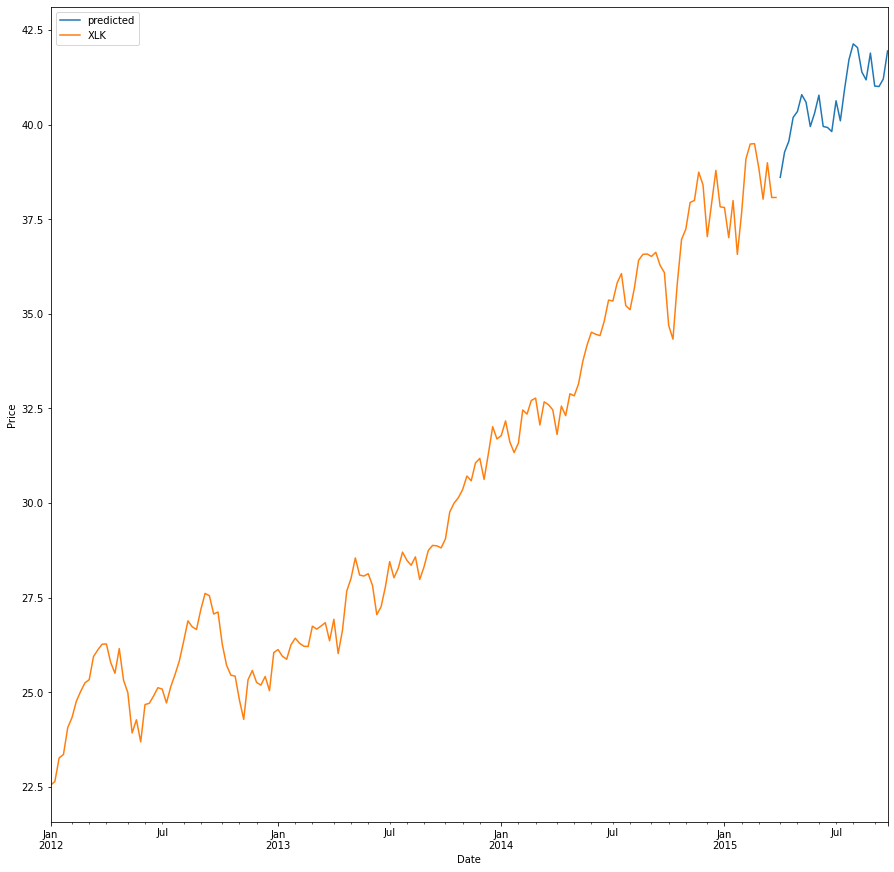

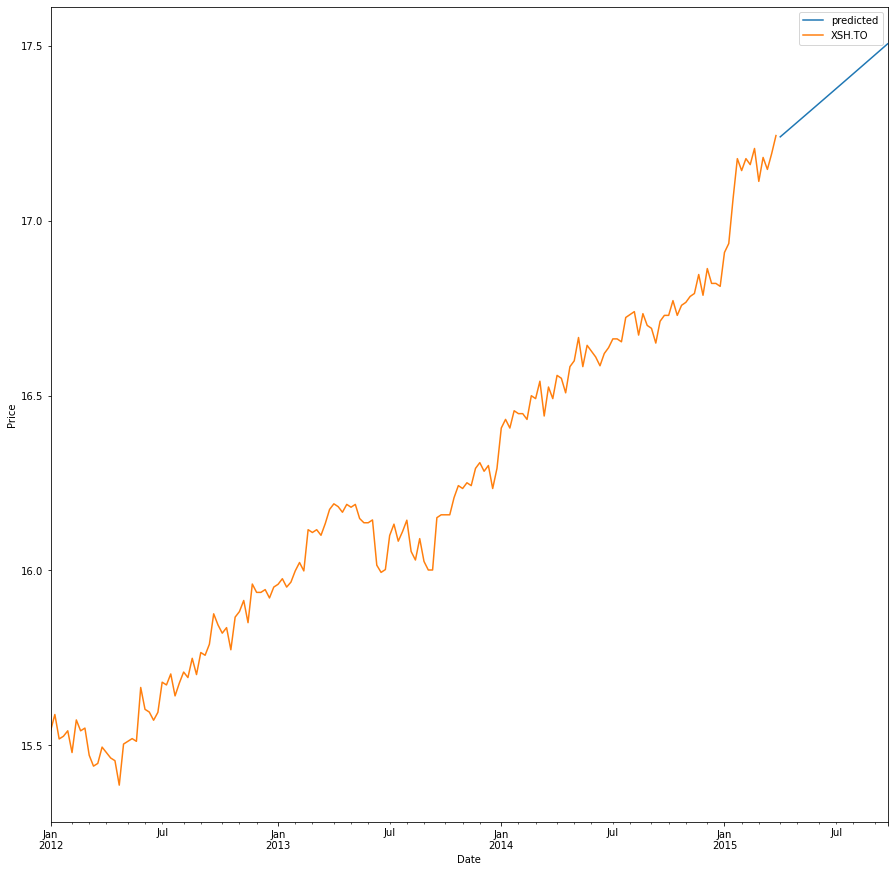

In [ ]:
# for j in range(1):
for j in range(num_of_forcast):
  forcast_monthly_return = [0]*len(df.columns)
  # loop inside relablance

  invest_start_day = invest_end_day
  invest_end_day = invest_start_day + relativedelta(months=+6)
  # for last forcast period less than 6 months, use final day as last day
  if invest_end_day > final_day:
    invest_end_day = final_day

  end_day = invest_start_day - relativedelta(days=1)
  test_start_day = end_day - relativedelta(years=2)

  test = df[invest_start_day:invest_end_day]

  #for i in range(1):
  for i in range(len(df.columns)):
  # for model selection 
    series = df[:end_day]
    series = series.iloc[:,i].dropna()
    param_optimal, param_seasonal_optimal, aic = optimal_para_selection(series,i)
    # results = evaluate_model(series,param_optimal, param_seasonal_optimal)
    # evaluate_plot(series, results,test_start_day,plot_start_day) 

    # for rebalance
    series_train = series # [test_start_day:end_day]
    train_result = train_model(series_train,param_optimal, param_seasonal_optimal)
    # test data frame adding the predicted value
    test = prediction(train_result,i)
    # print(test.head())
    #  performance of first rebalancing 
    if j==0:
      investment_plot_no_actual(i,series_train,numOfETF)
    # calculate monthly return
    forcast_monthly_return[i] = test['pred'+str(i)].resample('M').ffill().pct_change().dropna().mean()
  forcast_monthly_return_table[invest_end_day] = forcast_monthly_return
forcast_monthly_return_table.to_csv("expected_return_rebalance.csv")

In [ ]:
### backtesting

In [ ]:

# data = yf.download(tickers=tickers, start="2012-01-01", end=invest_end_day,interval='1wk')
final_day = datetime.strptime('2015-03-31', '%Y-%m-%d').date()
df = yf.download(tickers=tickers, start="2012-01-01", end=final_day,interval='1wk')['Adj Close'].dropna()
numOfETF = len(df.columns)
 # reduce dataframe to rows, where all asset prices are present
plot_start_day = '2012'
# initialize 
invest_end_day = datetime.strptime("2014-03-31", '%Y-%m-%d').date()

# end_date = datetime.strptime(final_day, '%Y-%m-%d').date()
start_date = invest_end_day
num_months = (final_day.year - start_date.year) * 12 + (final_day.month - start_date.month)
num_of_forcast = math.ceil(num_months/6)

forcast_monthly_return_table_bt = pd.DataFrame()
print(num_of_forcast)


[*********************100%***********************]  14 of 14 completed
2


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1757      0.105     -1.676      0.094      -0.381       0.030
ma.S.L12      -0.0700      0.123     -0.567      0.571      -0.312       0.172
sigma2         0.1016      0.010      9.977      0.000       0.082       0.122


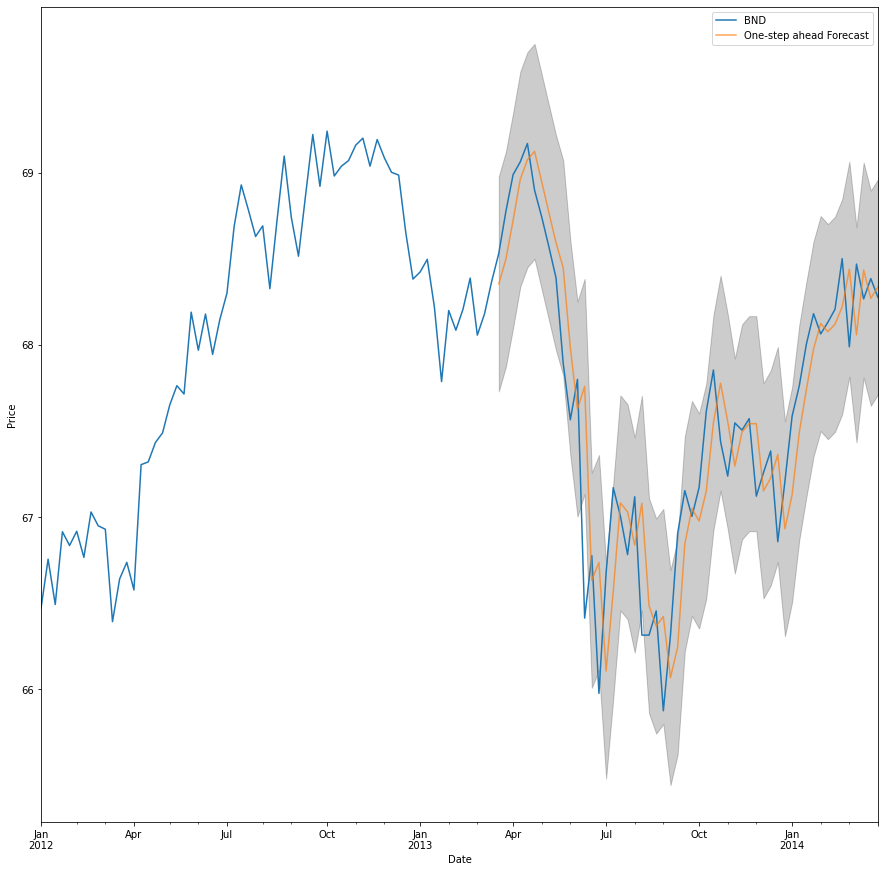

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0396      0.091      0.437      0.662      -0.138       0.217
ma.S.L12      -1.0000    963.905     -0.001      0.999   -1890.218    1888.218
sigma2        10.8620   1.05e+04      0.001      0.999   -2.05e+04    2.05e+04


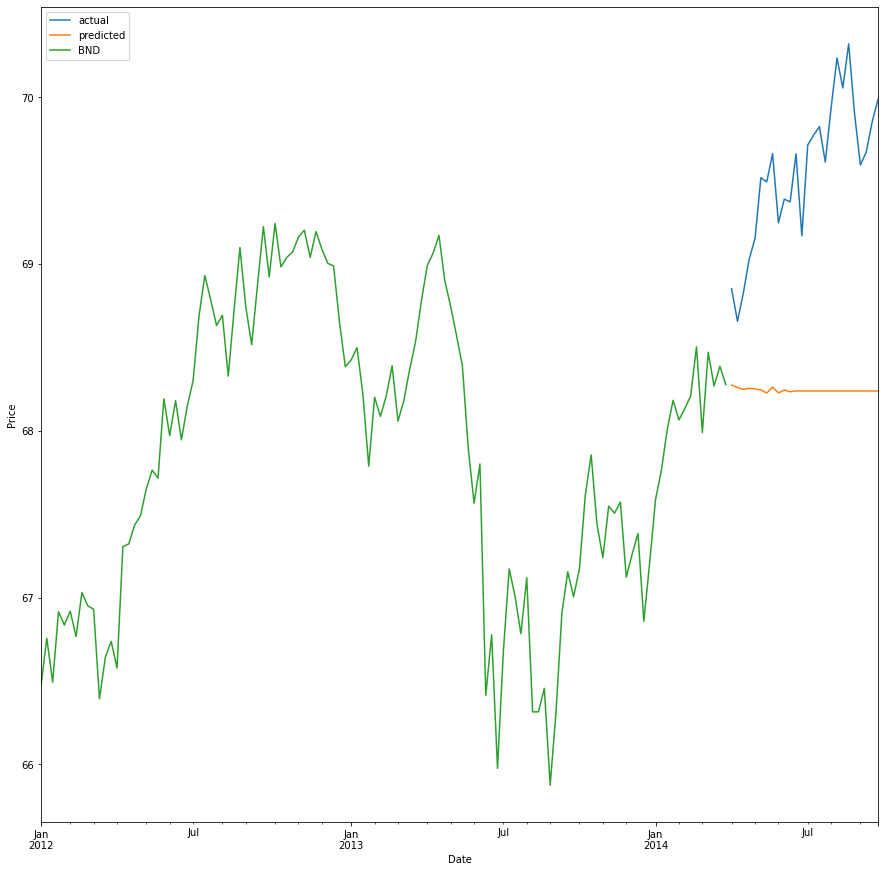

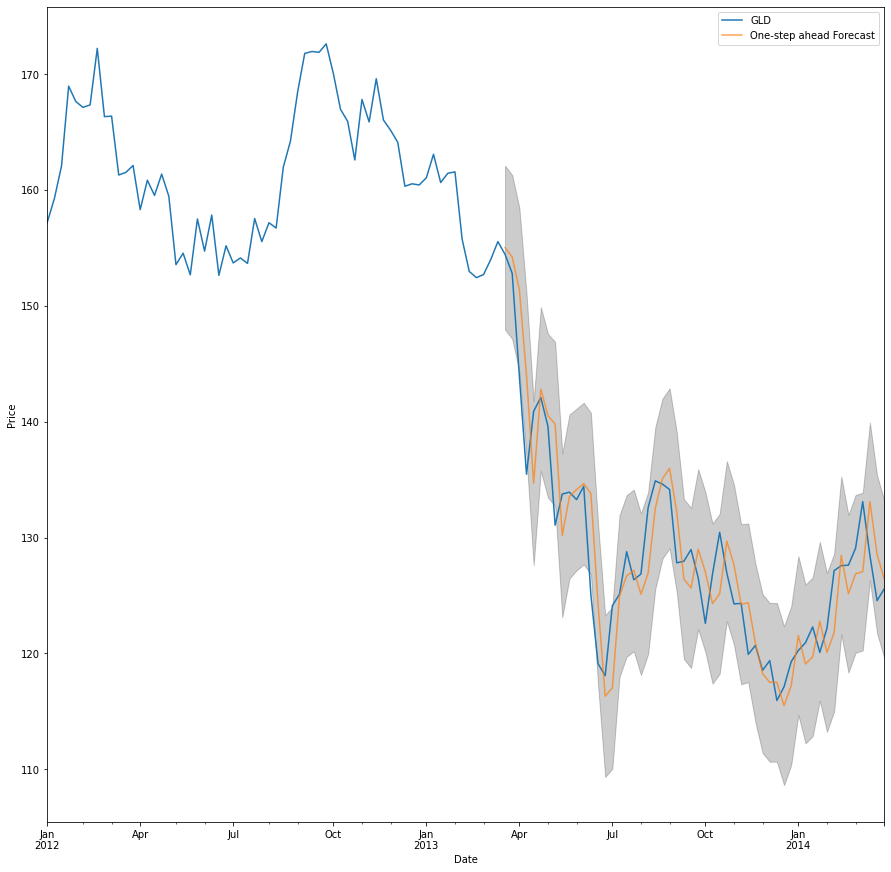

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0506      0.103     -0.491      0.623      -0.252       0.151
sigma2         0.1910      0.022      8.665      0.000       0.148       0.234


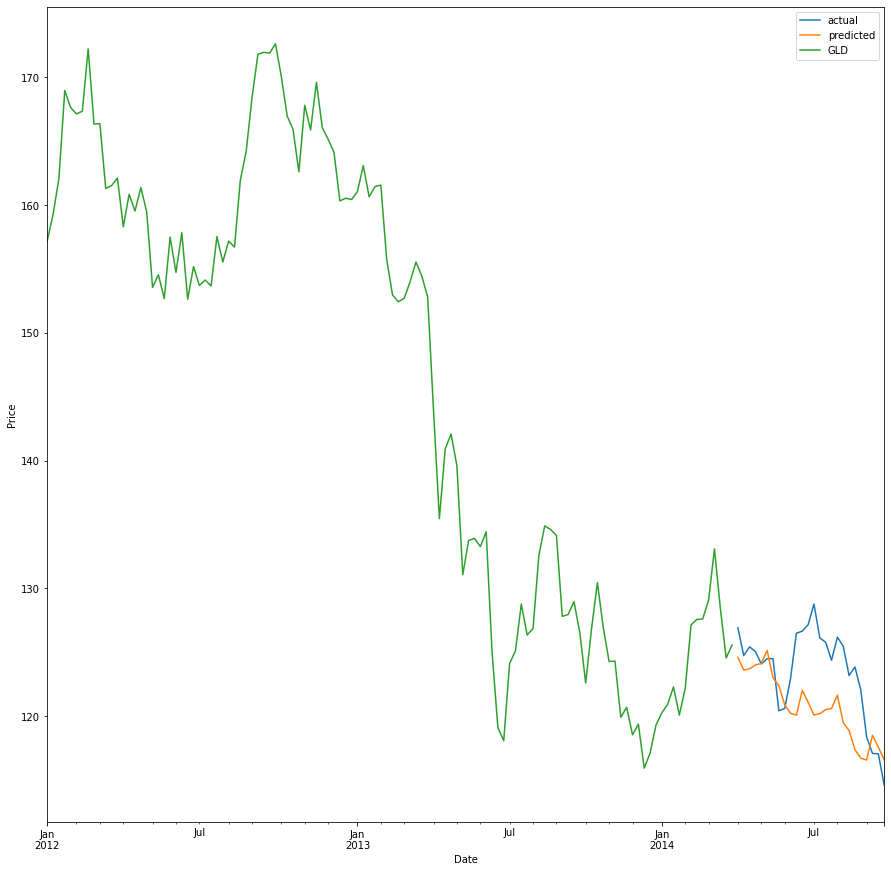

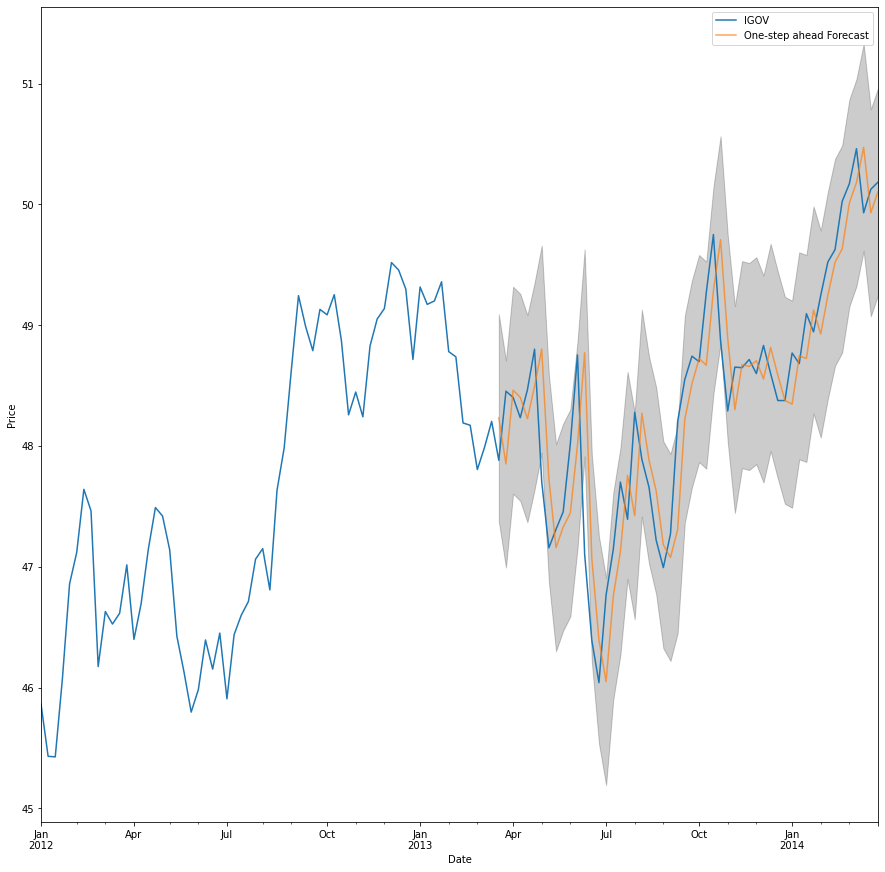

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0260      0.119     -0.219      0.827      -0.259       0.207
ma.S.L12      -0.8582      0.174     -4.944      0.000      -1.198      -0.518
sigma2         4.7095      0.906      5.200      0.000       2.934       6.485


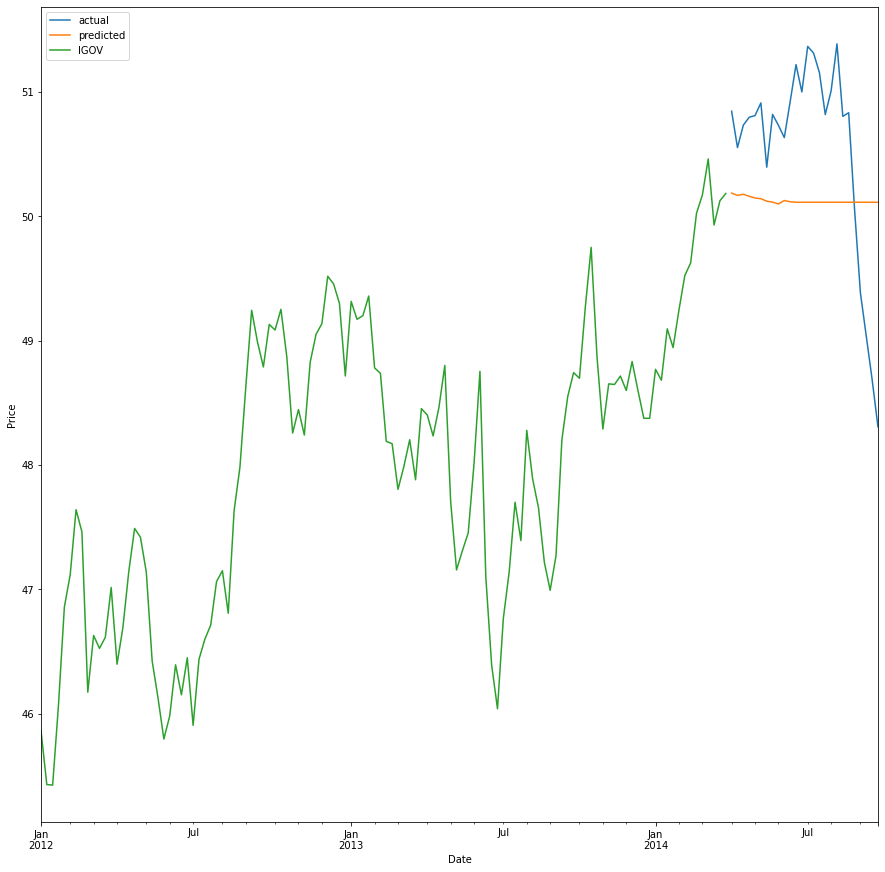

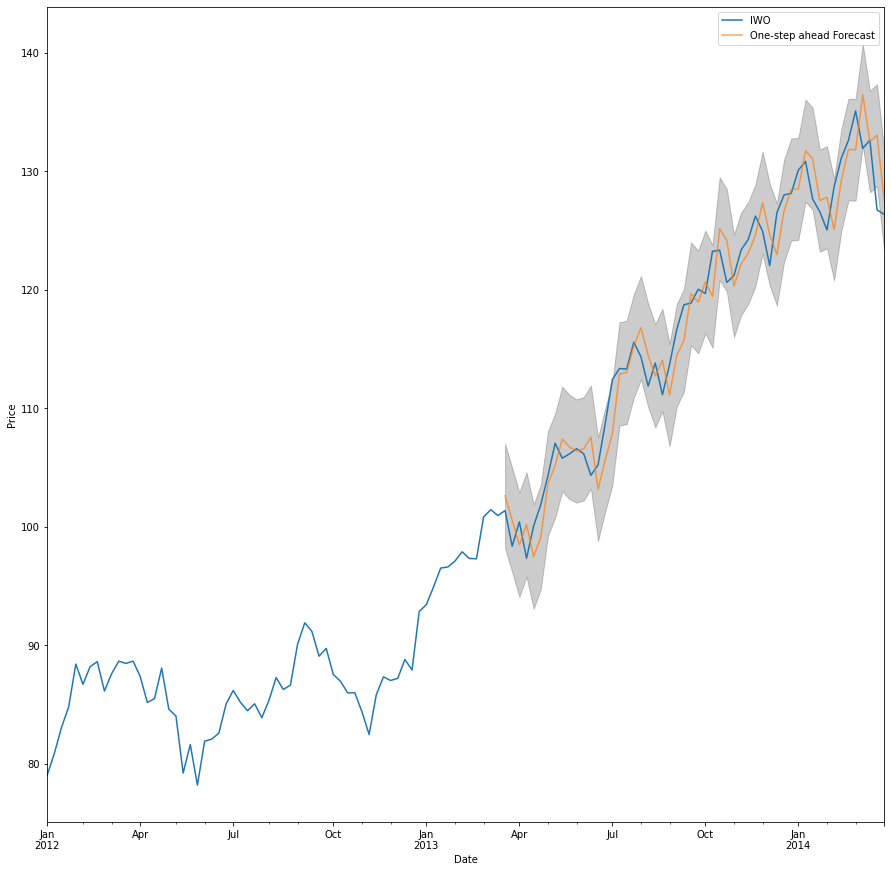

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0001   5.95e-05   1.68e+04      0.000       1.000       1.000
sigma2         0.0025      0.000      9.883      0.000       0.002       0.003


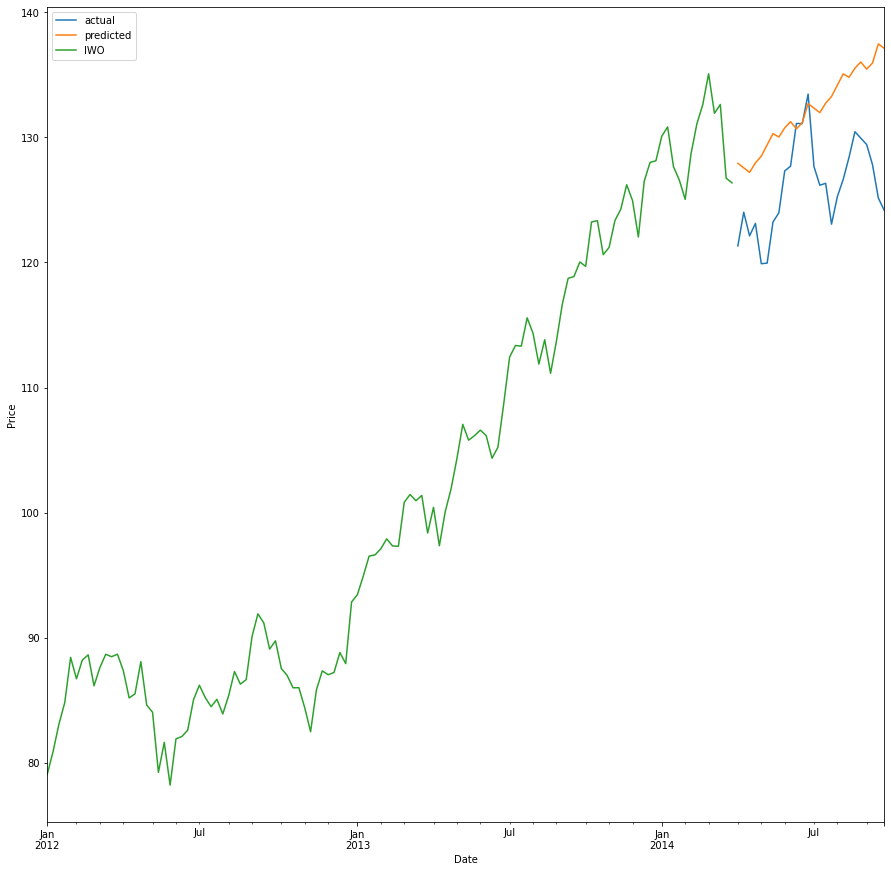

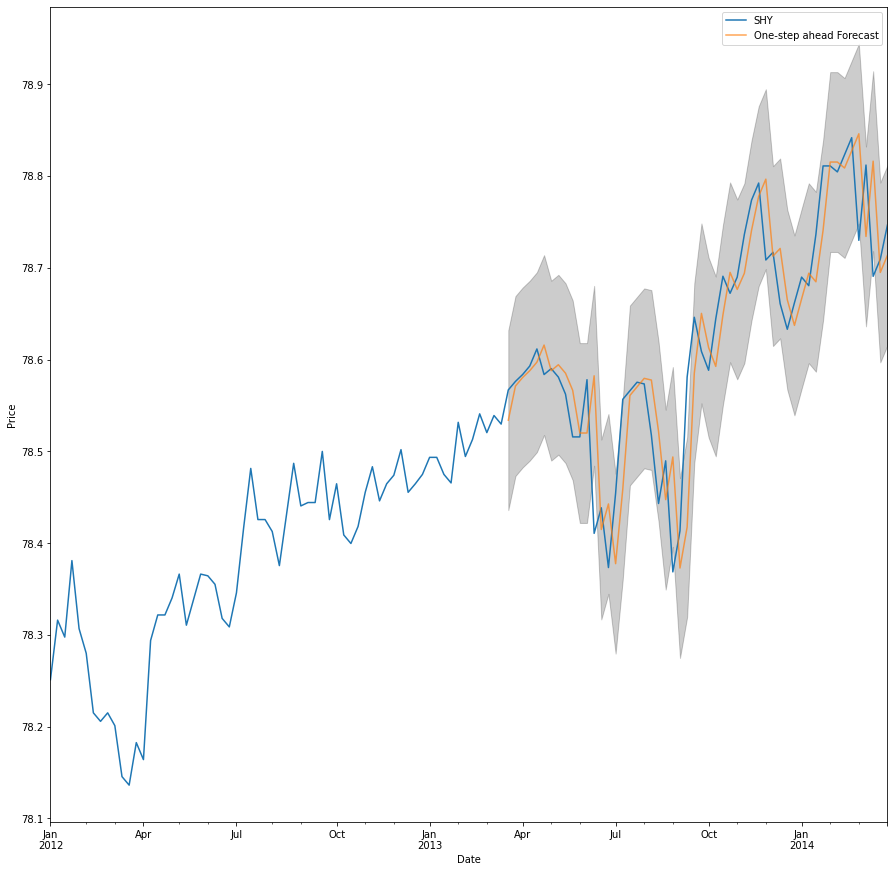

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0602      0.142     -0.424      0.672      -0.338       0.218
ma.S.L12      -1.0000   1418.103     -0.001      0.999   -2780.431    2778.431
sigma2         3.8608   5475.418      0.001      0.999   -1.07e+04    1.07e+04


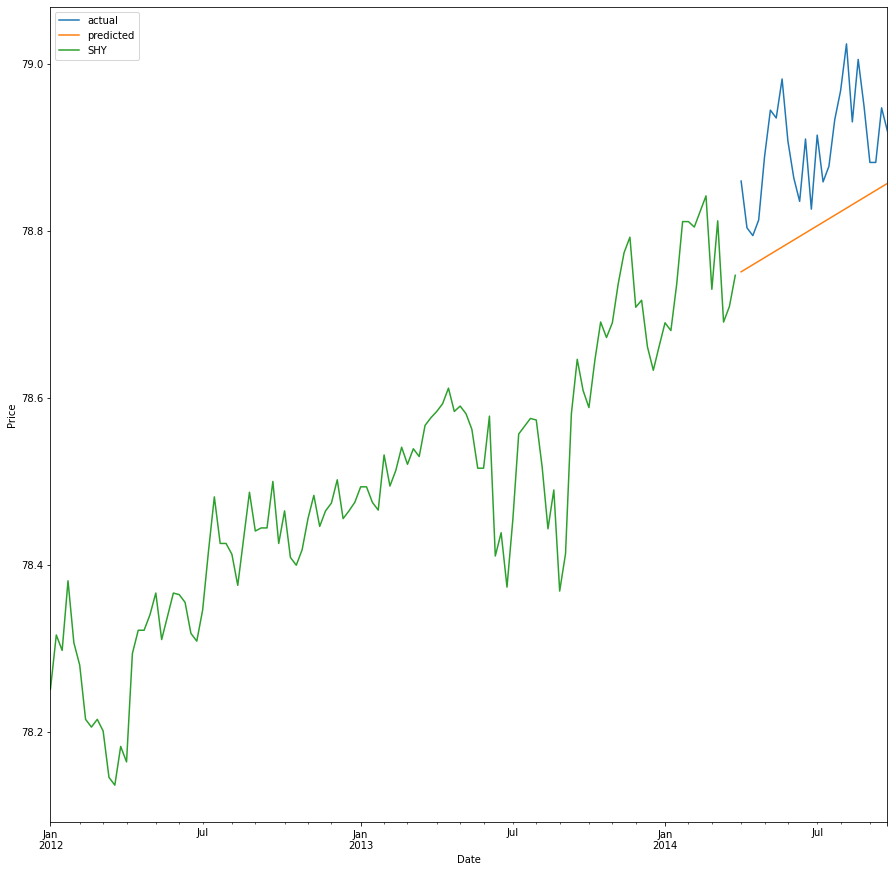

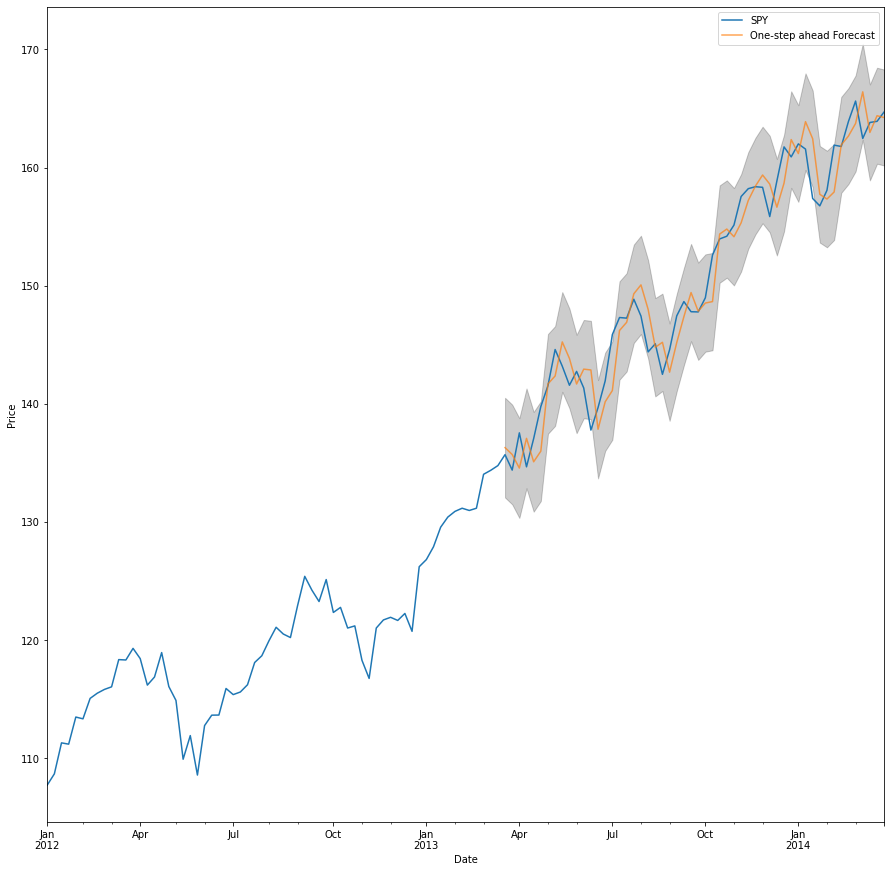

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0006      0.000   3753.158      0.000       1.000       1.001
sigma2         0.0321      0.002     14.942      0.000       0.028       0.036


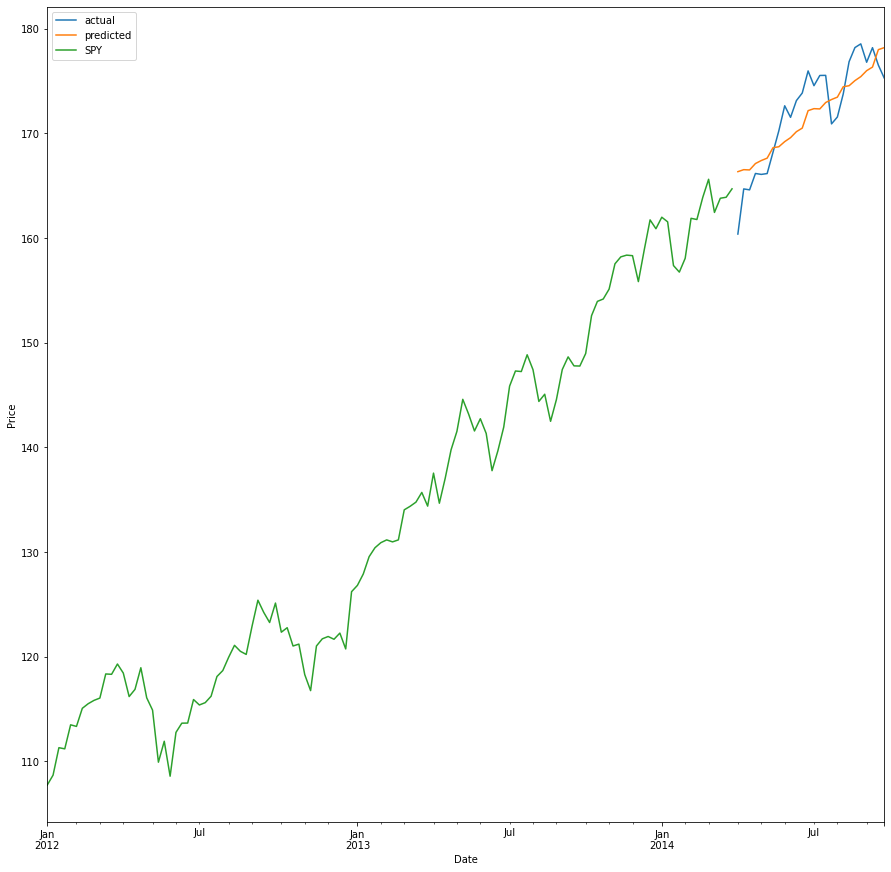

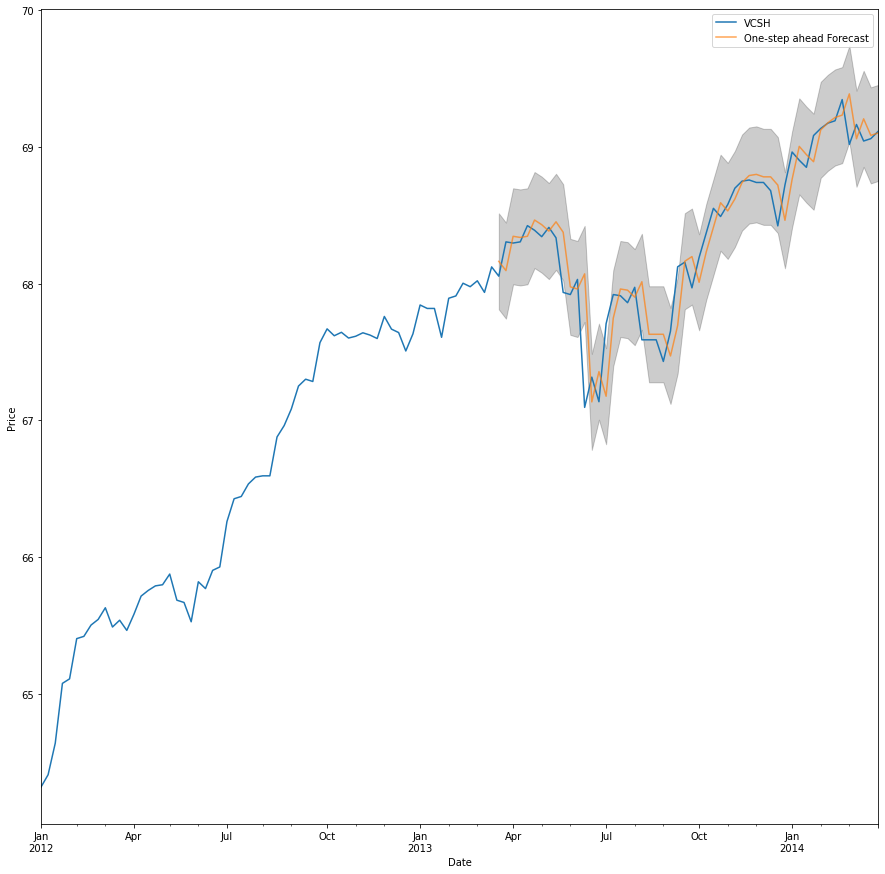

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0462      0.136      0.340      0.734      -0.220       0.313
ma.S.L12      -0.7748      0.113     -6.858      0.000      -0.996      -0.553
sigma2         1.5428      0.229      6.739      0.000       1.094       1.991


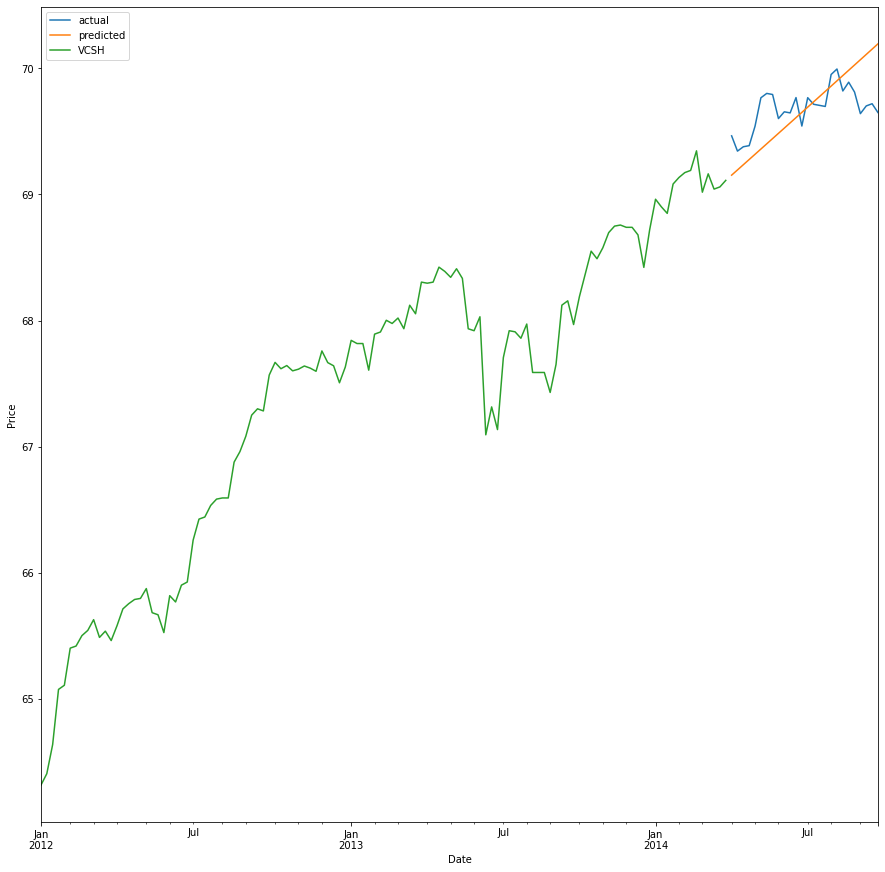

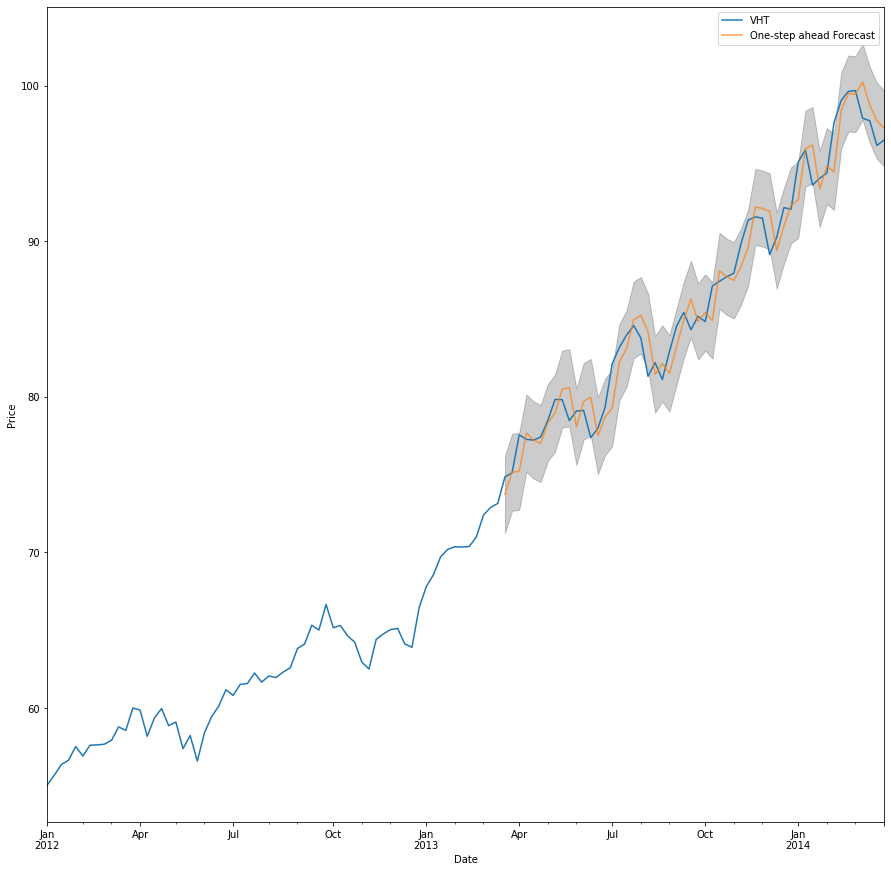

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0470      0.107     -0.440      0.660      -0.257       0.163
ma.S.L12      -0.8072      0.104     -7.775      0.000      -1.011      -0.604
sigma2         1.3682      0.199      6.880      0.000       0.978       1.758


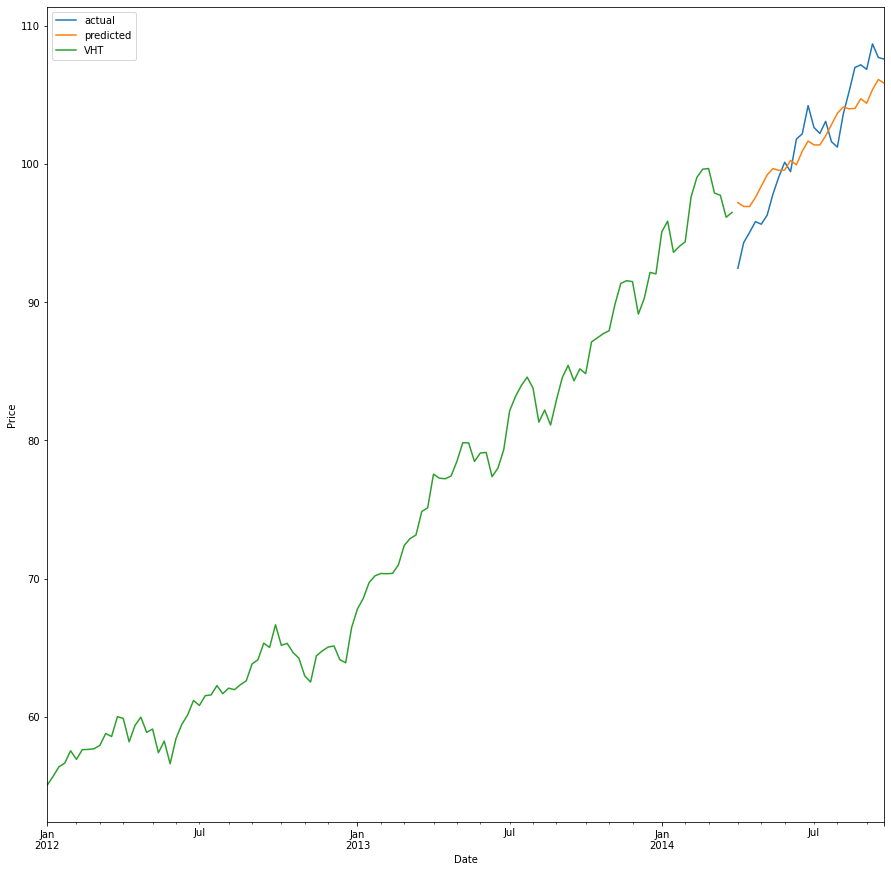

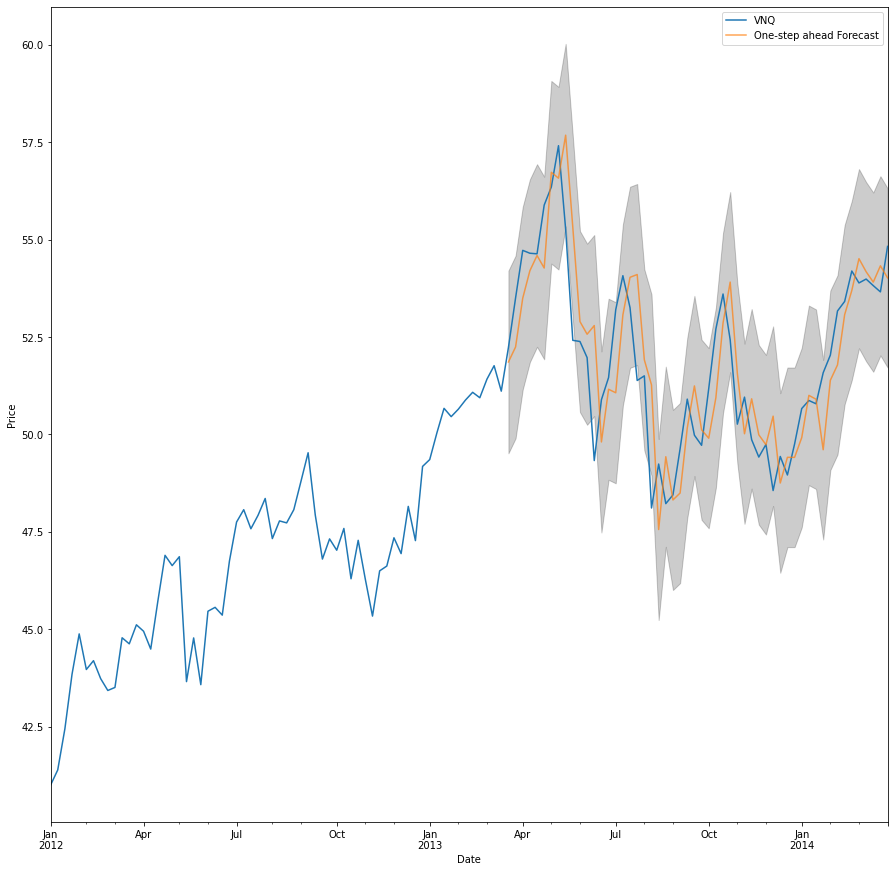

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9100      0.057    -16.023      0.000      -1.021      -0.799
ma.L1          0.9500      0.076     12.488      0.000       0.801       1.099
ma.S.L12      -0.8831      0.236     -3.738      0.000      -1.346      -0.420
sigma2         0.4868      0.126      3.855      0.000       0.239       0.734


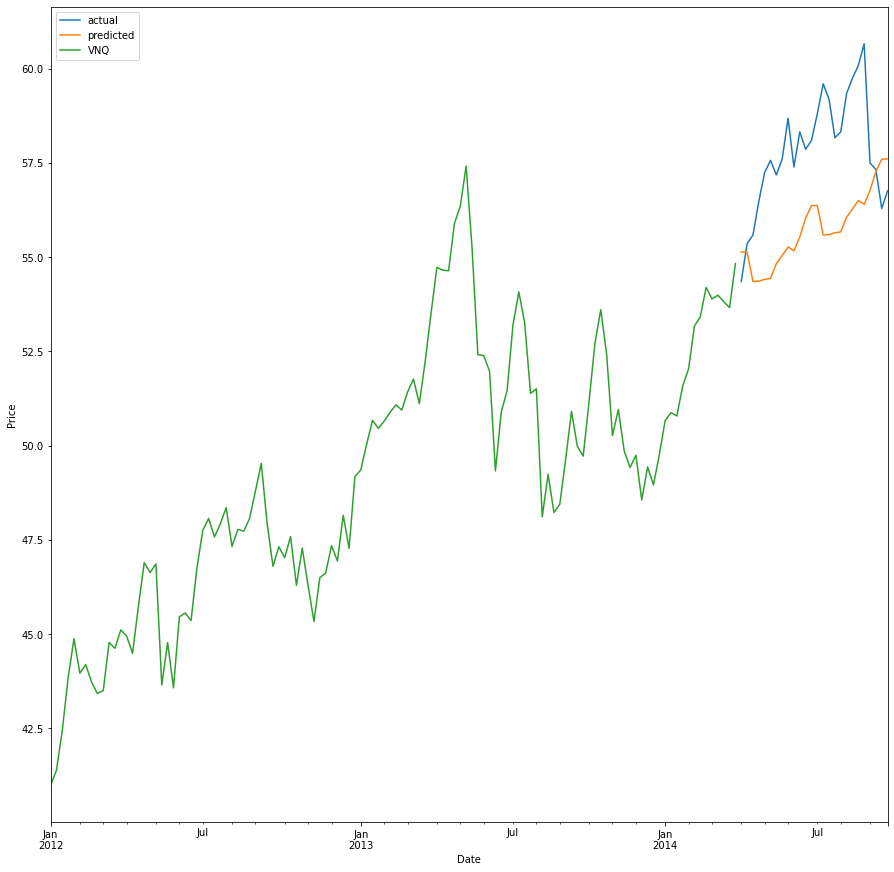

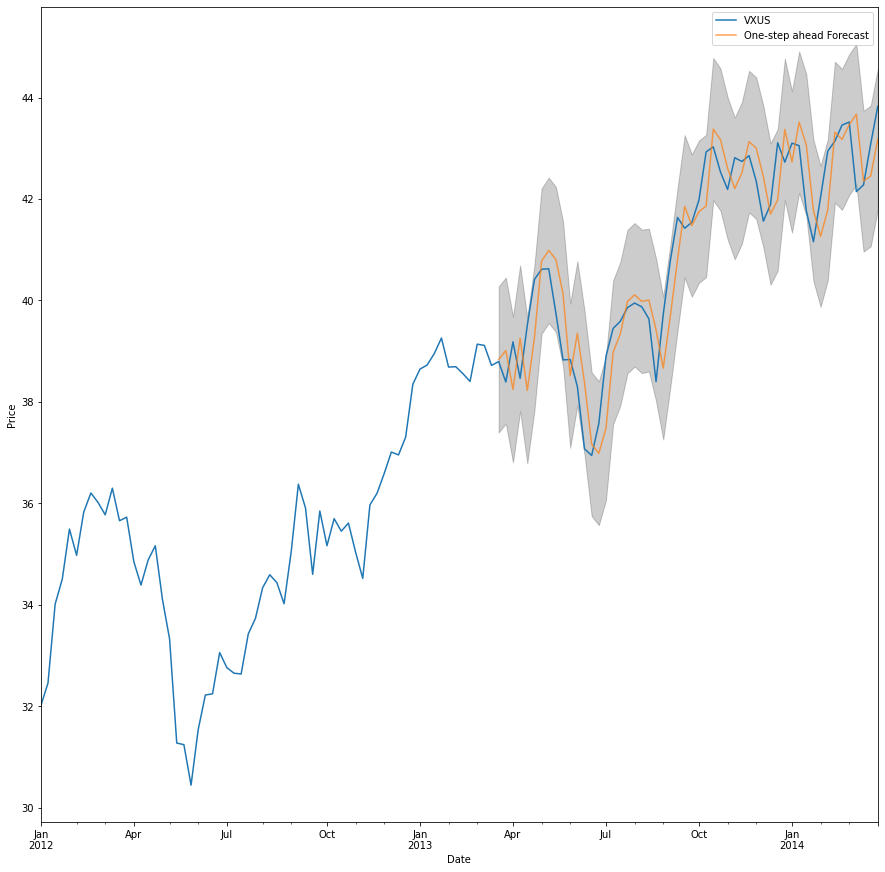

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2134      0.111     -1.924      0.054      -0.431       0.004
sigma2         0.0203      0.002      9.570      0.000       0.016       0.024


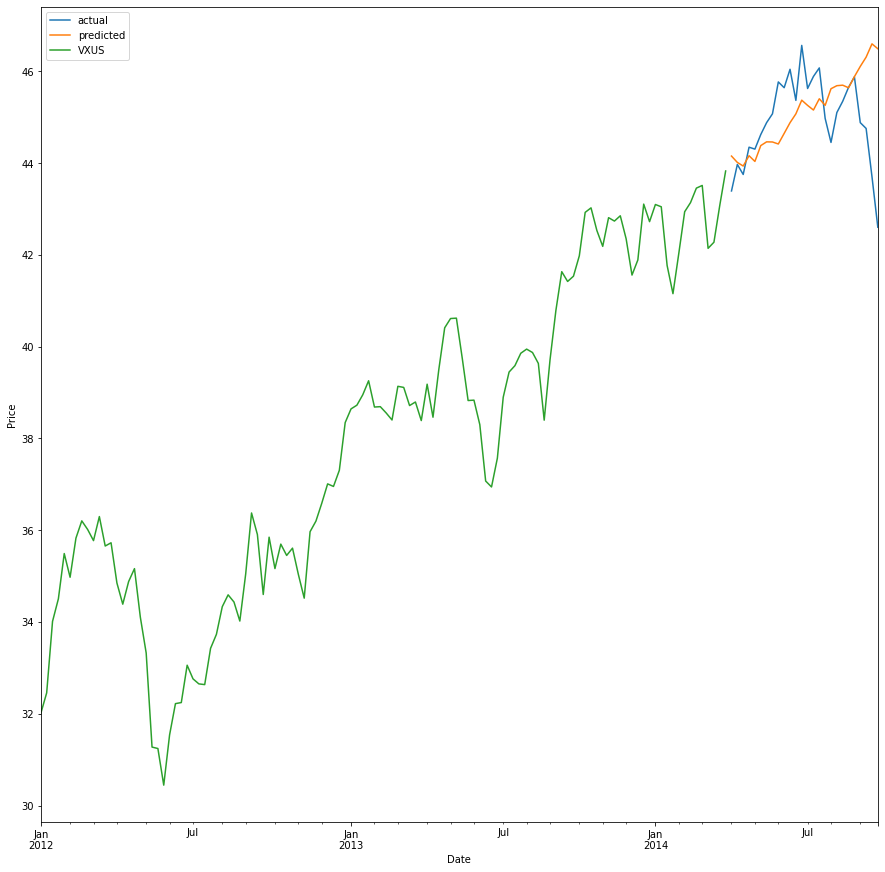

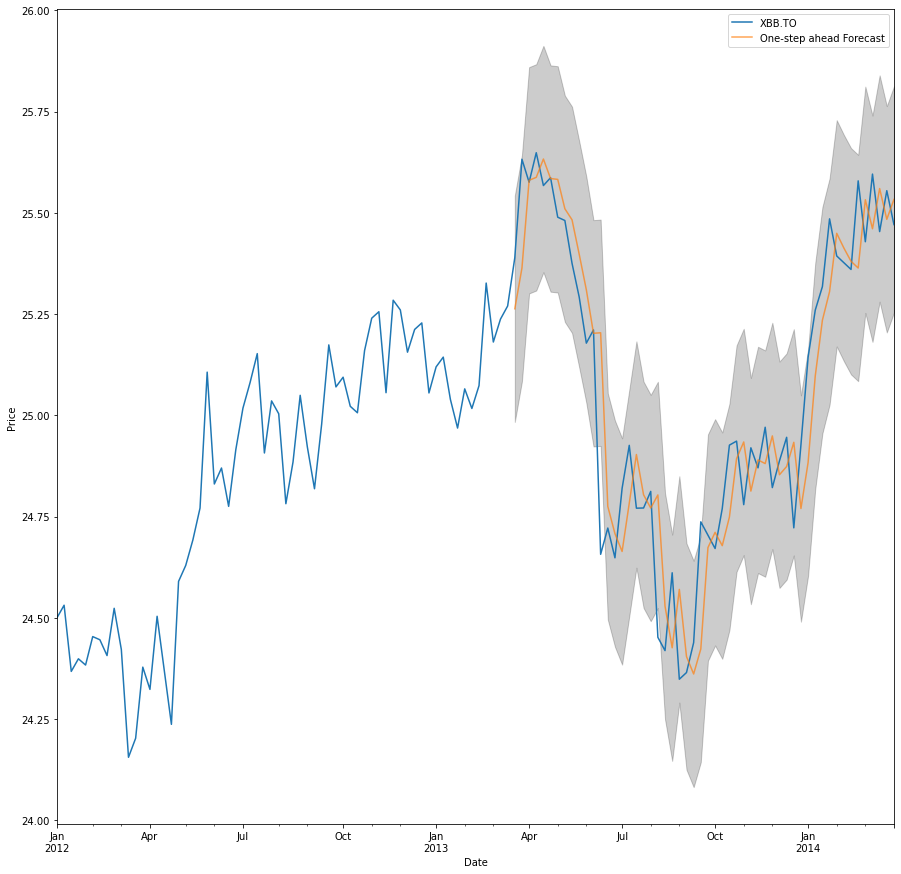

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0021      0.001    795.577      0.000       1.000       1.005
sigma2         0.0434      0.006      6.835      0.000       0.031       0.056


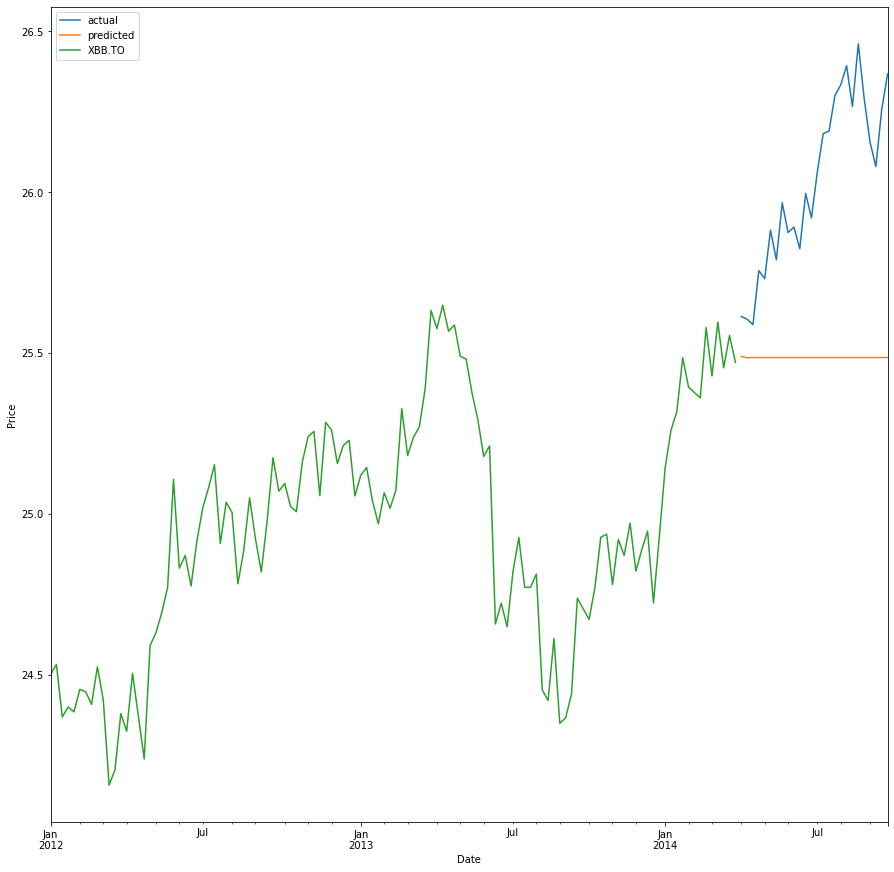

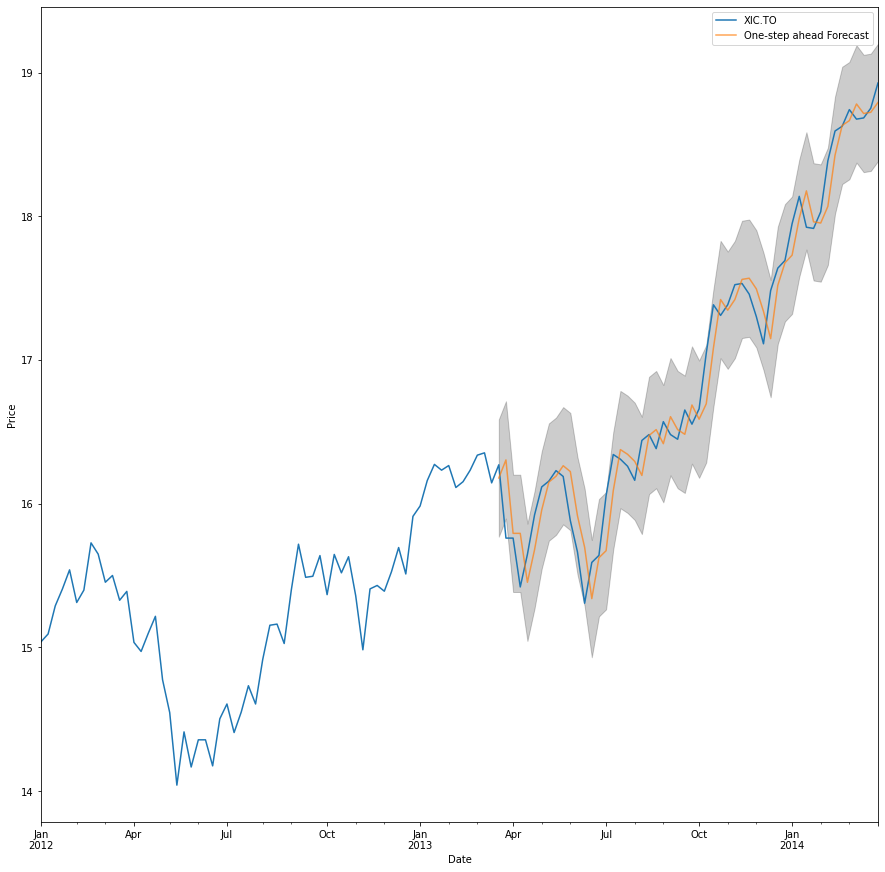

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000    892.272     -0.001      0.999   -1749.822    1747.822
sigma2         0.1933    172.452      0.001      0.999    -337.807     338.194


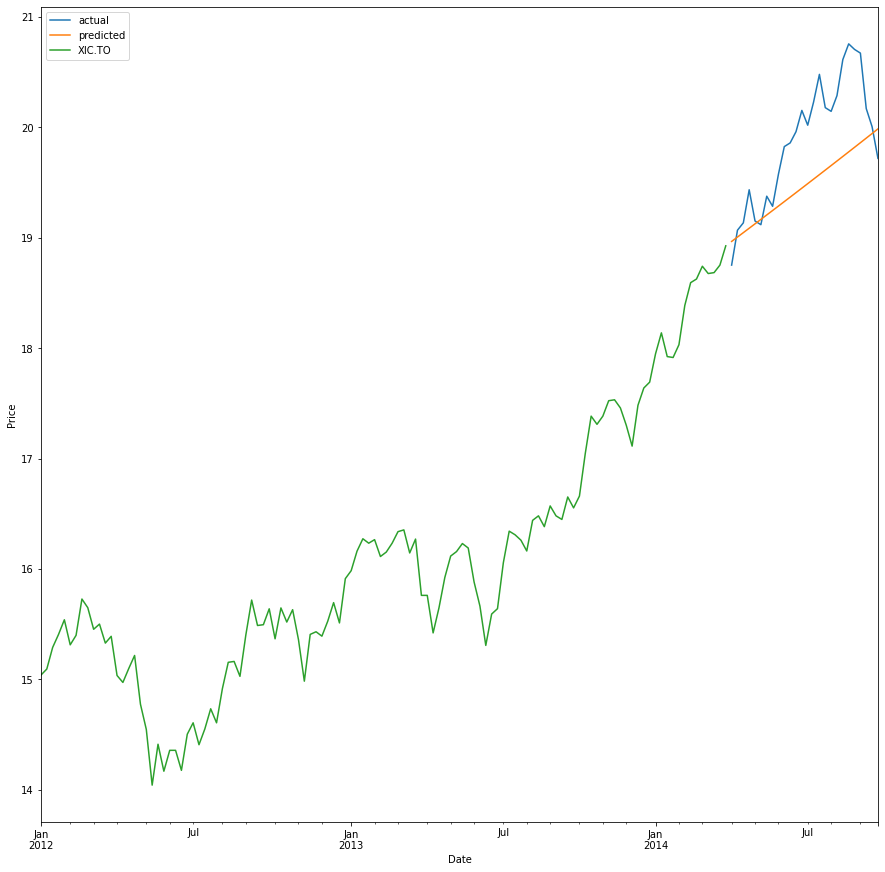

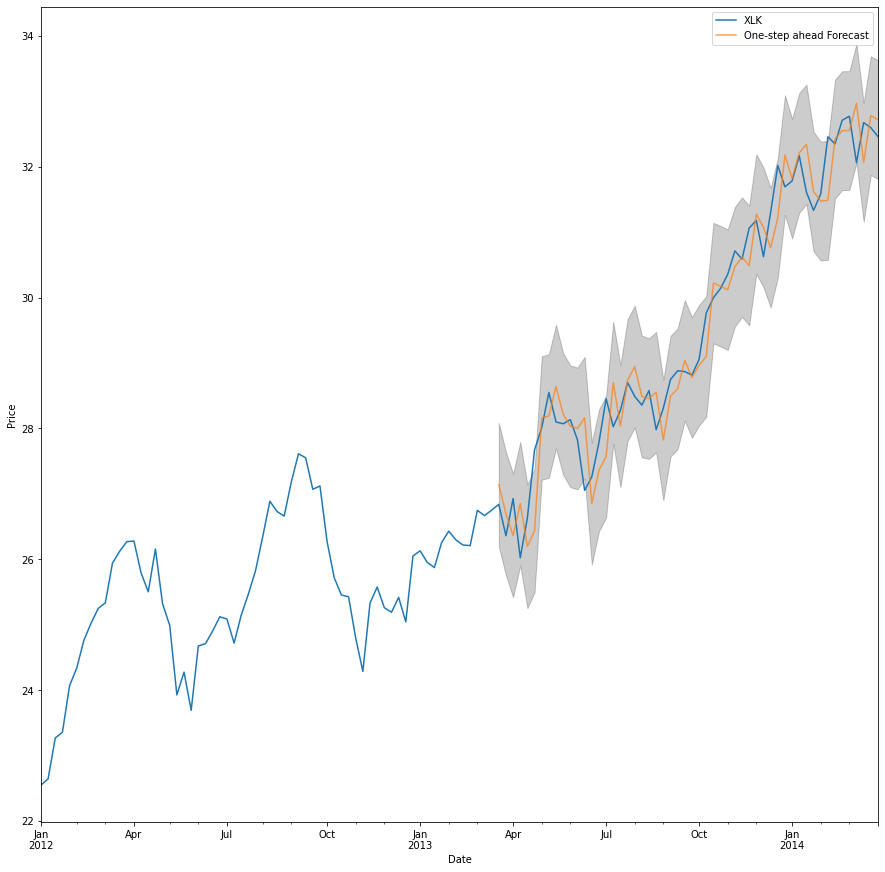

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.000   4840.163      0.000       1.000       1.001
ma.L1         -0.2979      0.099     -3.000      0.003      -0.492      -0.103
sigma2         0.0023      0.000      8.737      0.000       0.002       0.003


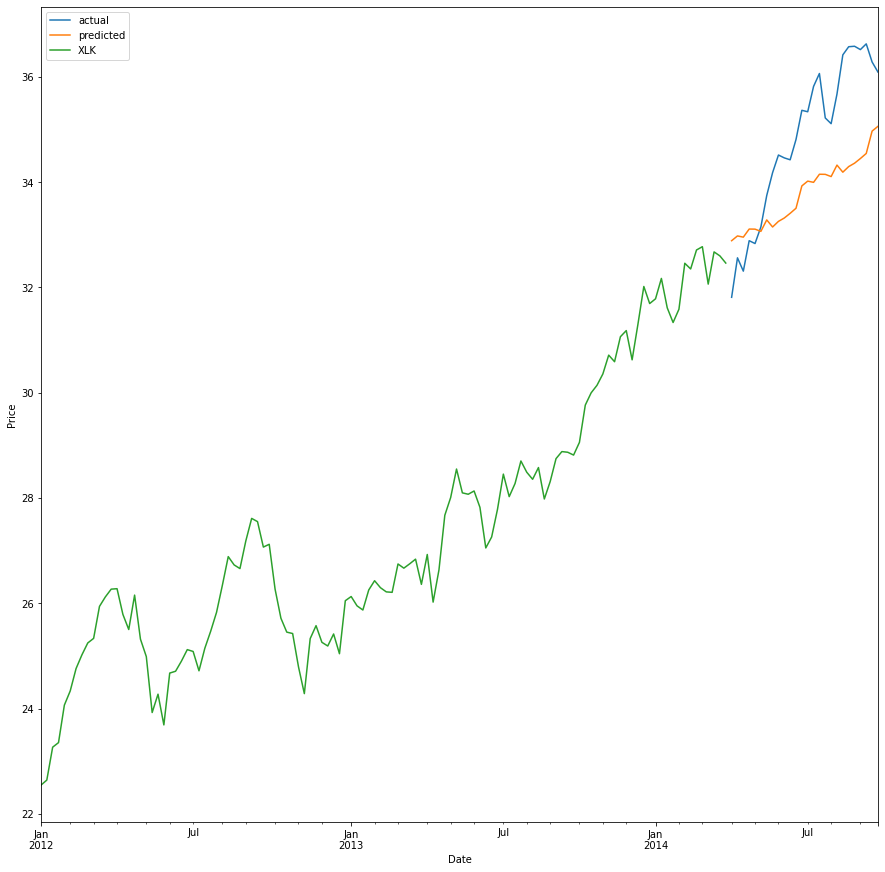

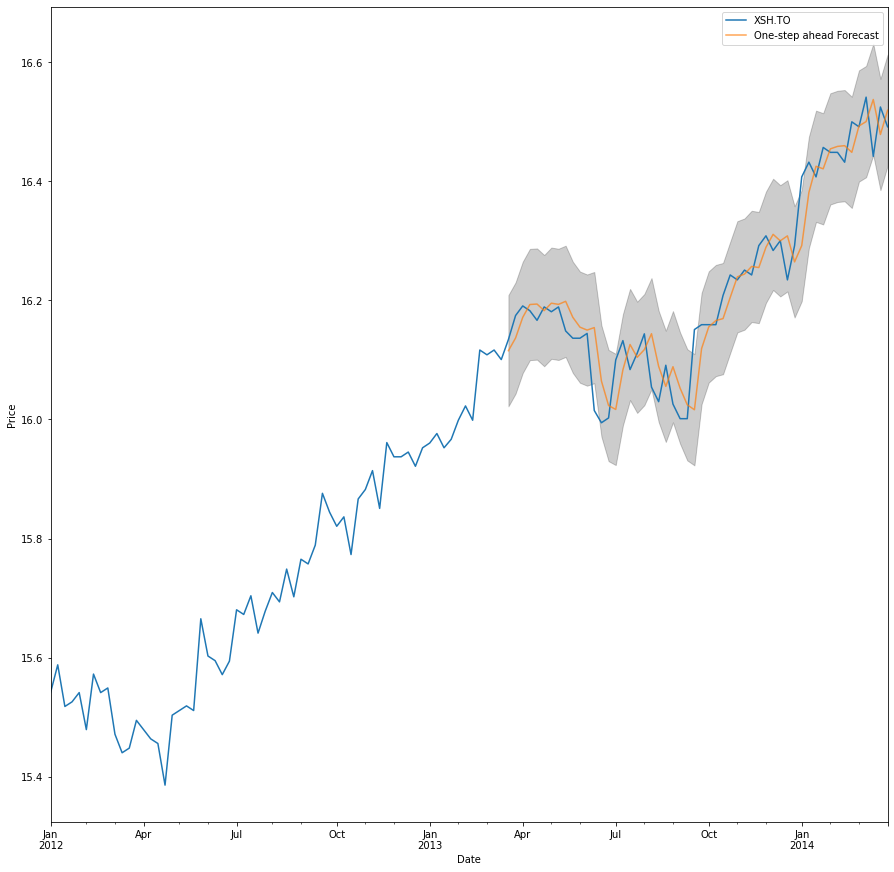

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1800      0.094     -1.906      0.057      -0.365       0.005
ma.S.L12      -0.0817      0.106     -0.775      0.439      -0.289       0.125
sigma2         0.0959      0.009     10.852      0.000       0.079       0.113


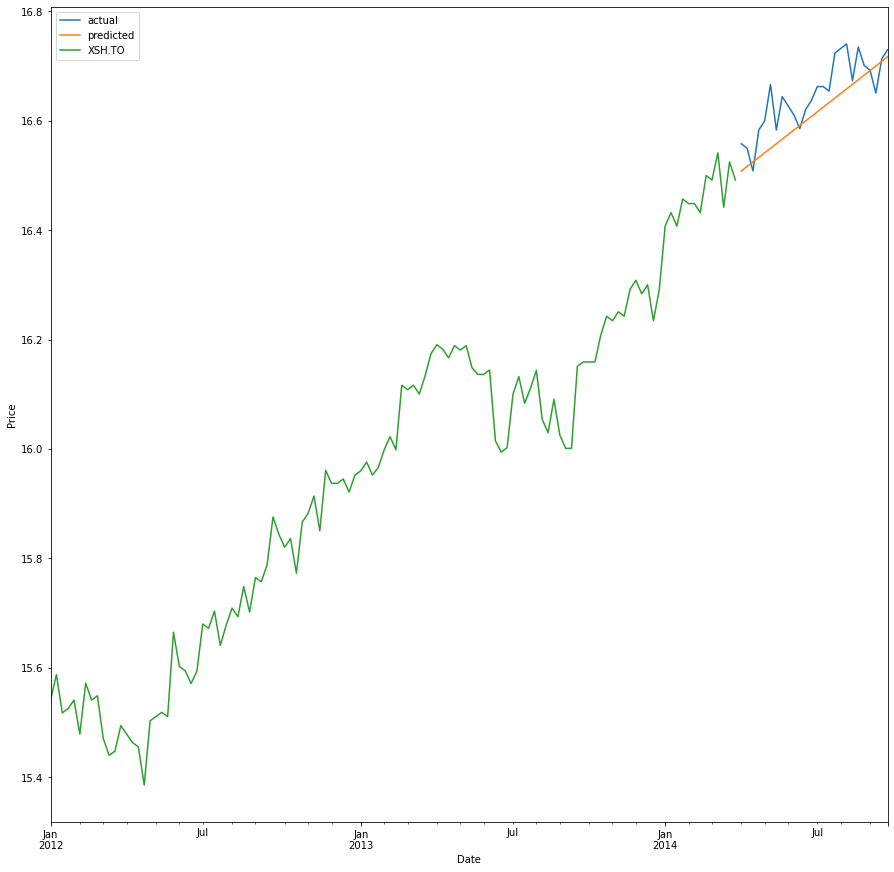

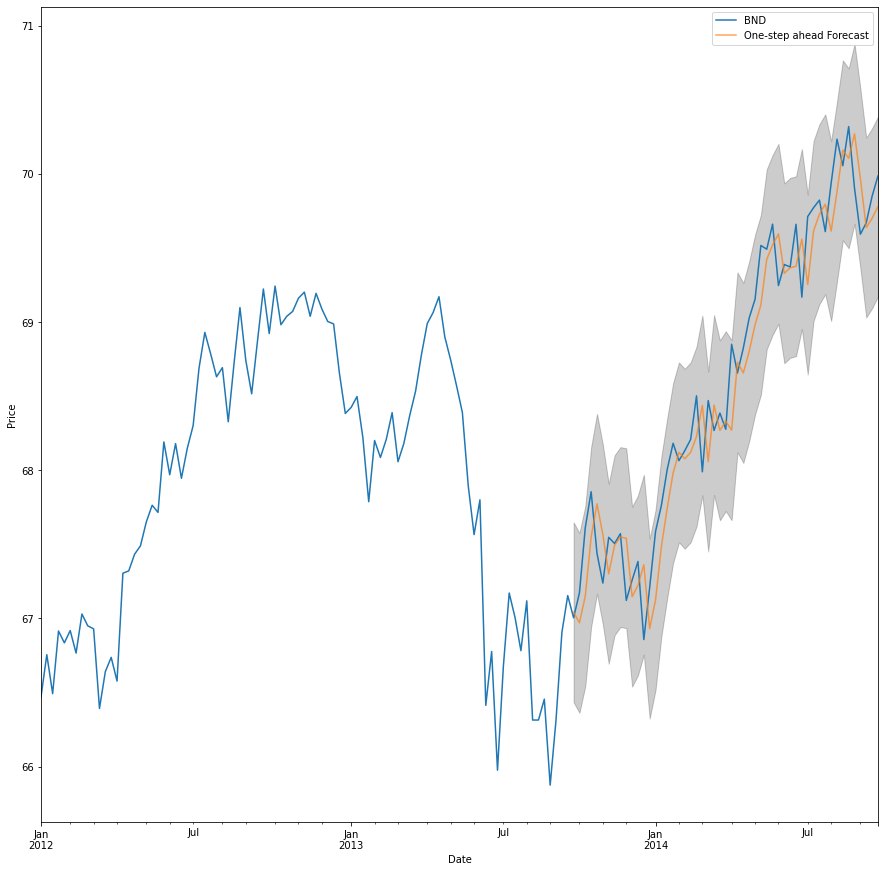

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0313      0.077      0.407      0.684      -0.120       0.182
ma.S.L12      -1.0000   1352.904     -0.001      0.999   -2652.644    2650.644
sigma2         9.3148   1.26e+04      0.001      0.999   -2.47e+04    2.47e+04


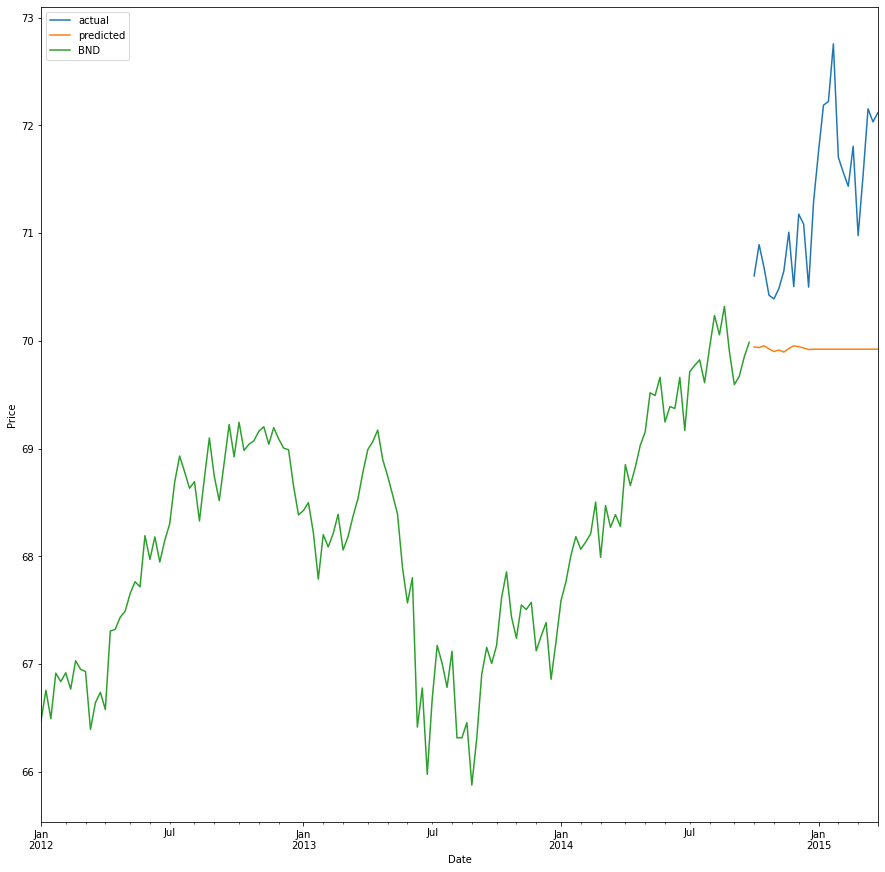

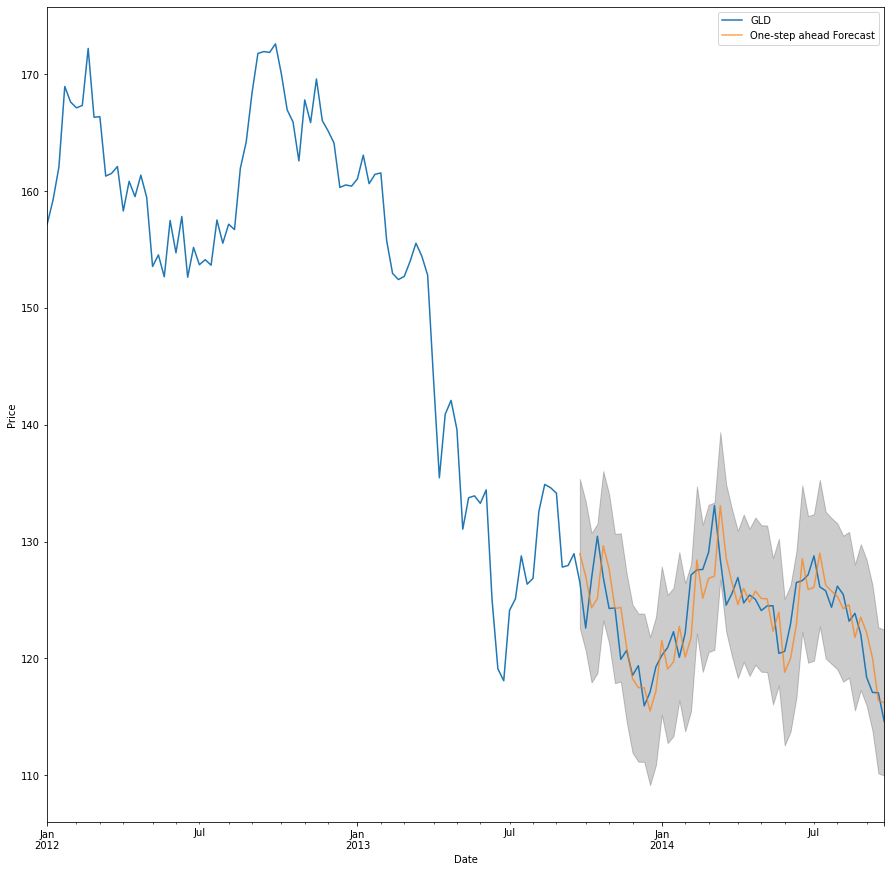

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0913      0.093     -0.979      0.328      -0.274       0.092
sigma2         0.1784      0.019      9.542      0.000       0.142       0.215


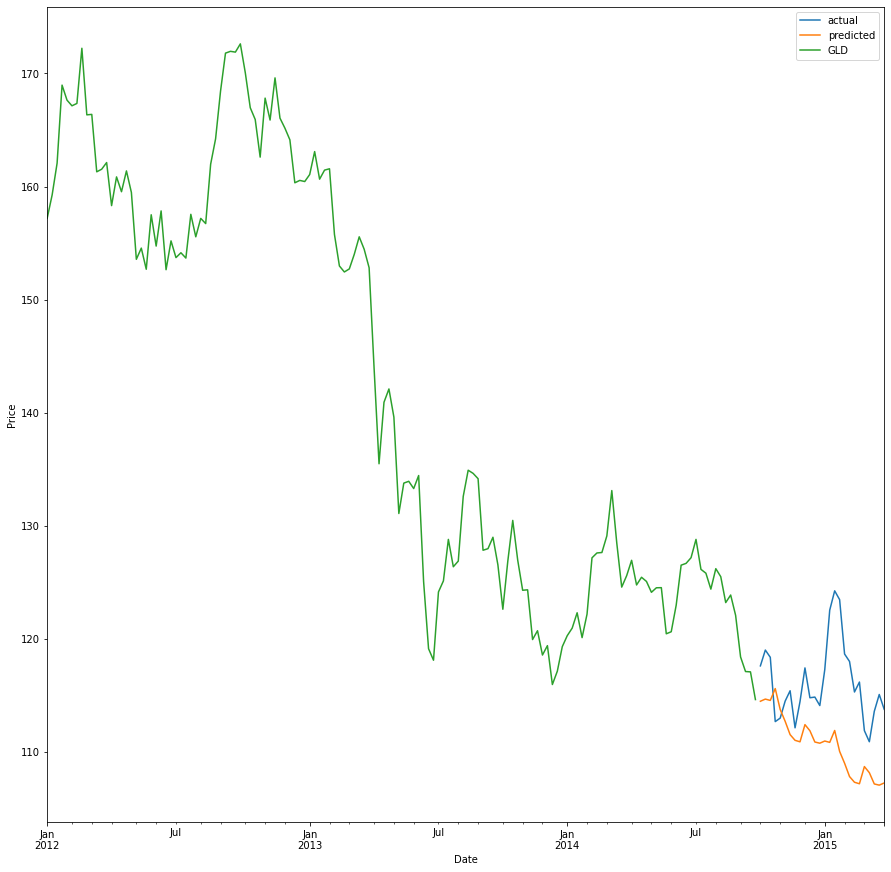

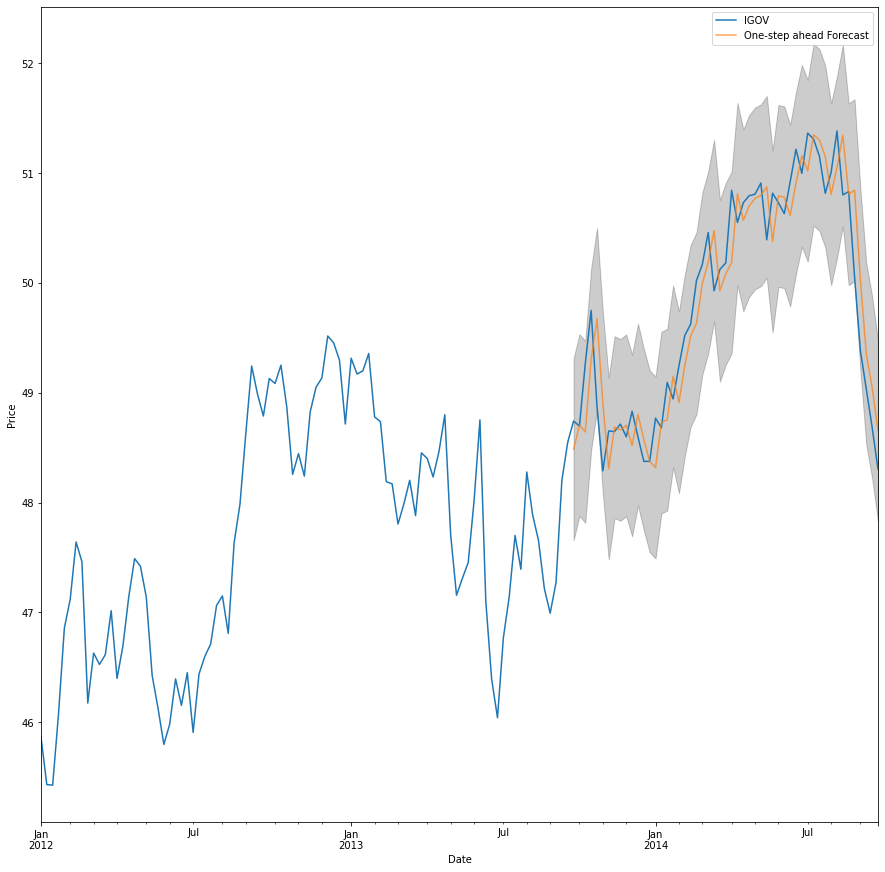

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6729      0.238     -2.825      0.005      -1.140      -0.206
ma.L1          0.5454      0.287      1.898      0.058      -0.018       1.109
ar.S.L12      -0.3725      0.110     -3.393      0.001      -0.588      -0.157
ma.S.L12      -0.5780      0.109     -5.321      0.000      -0.791      -0.365
sigma2         5.0876      0.754      6.744      0.000       3.609       6.566


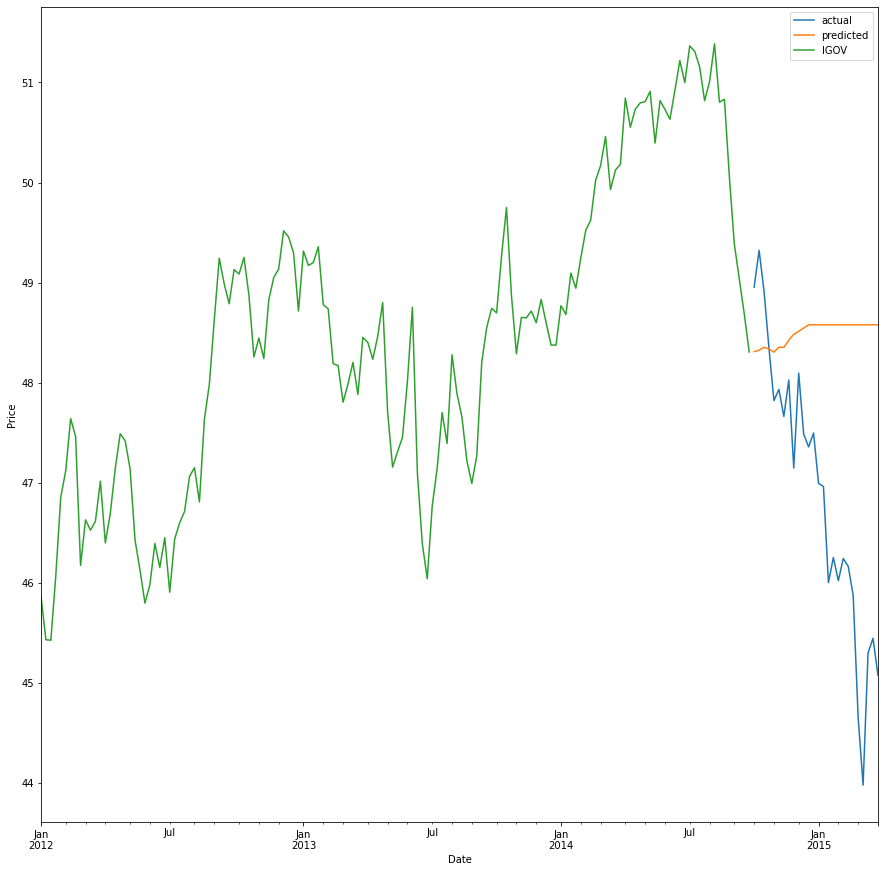

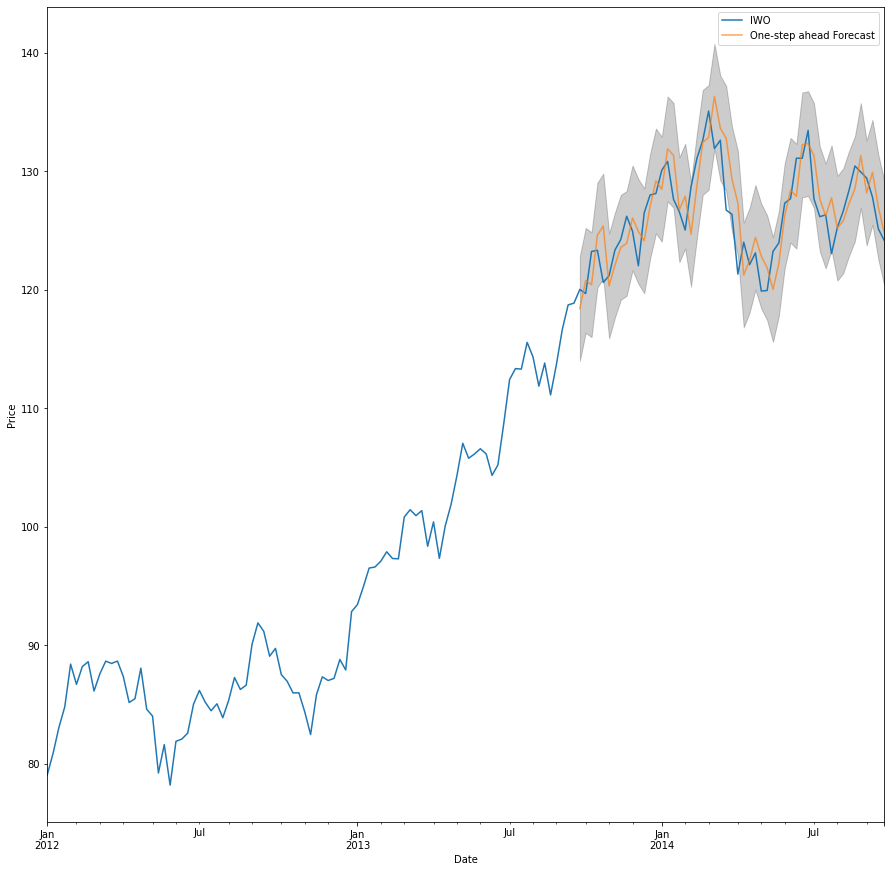

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1721      0.075     -2.310      0.021      -0.318      -0.026
sigma2         0.0026      0.000      9.725      0.000       0.002       0.003


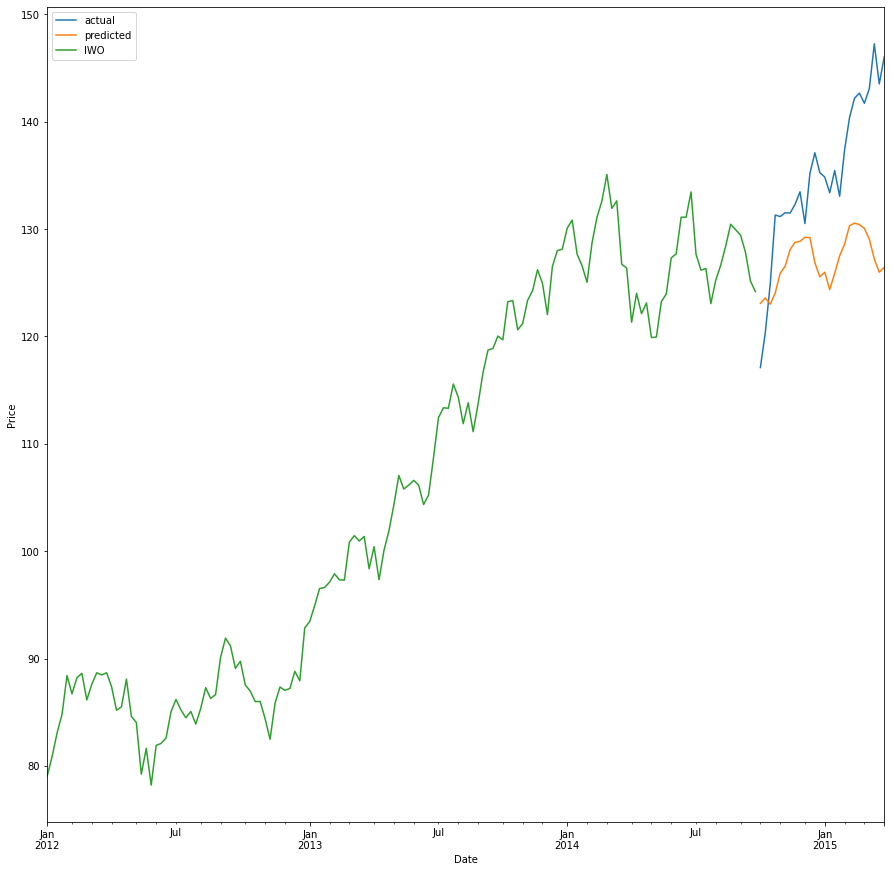

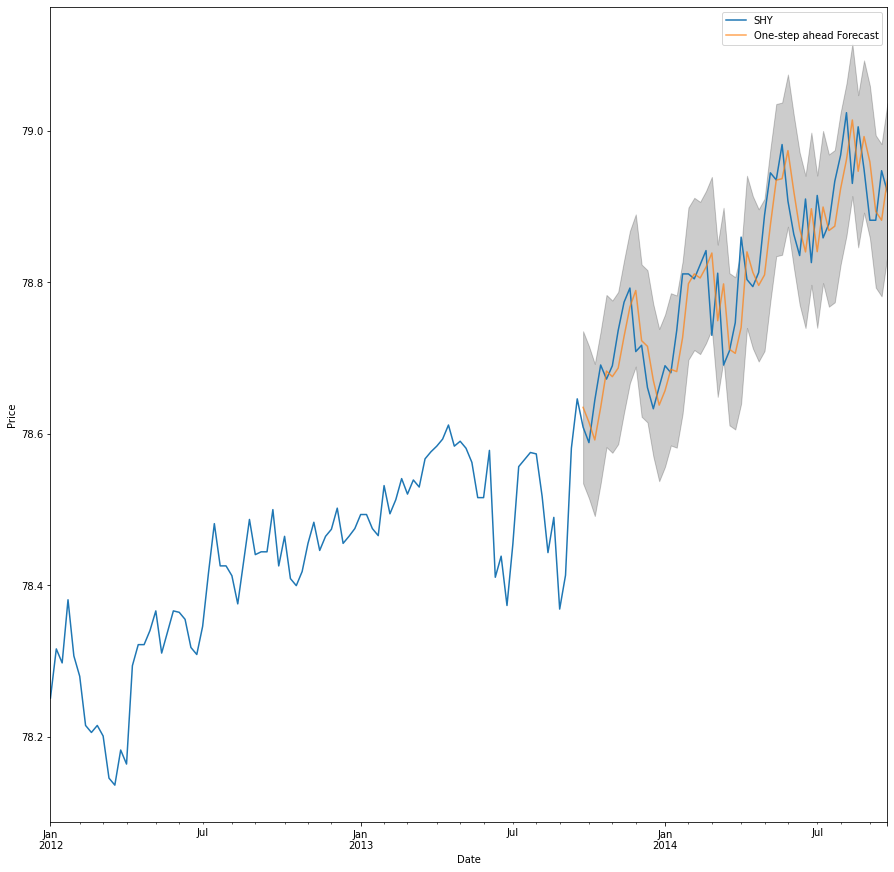

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0959      0.114     -0.841      0.401      -0.320       0.128
ma.S.L12      -0.9551      0.367     -2.600      0.009      -1.675      -0.235
sigma2         4.1051      1.306      3.143      0.002       1.545       6.665


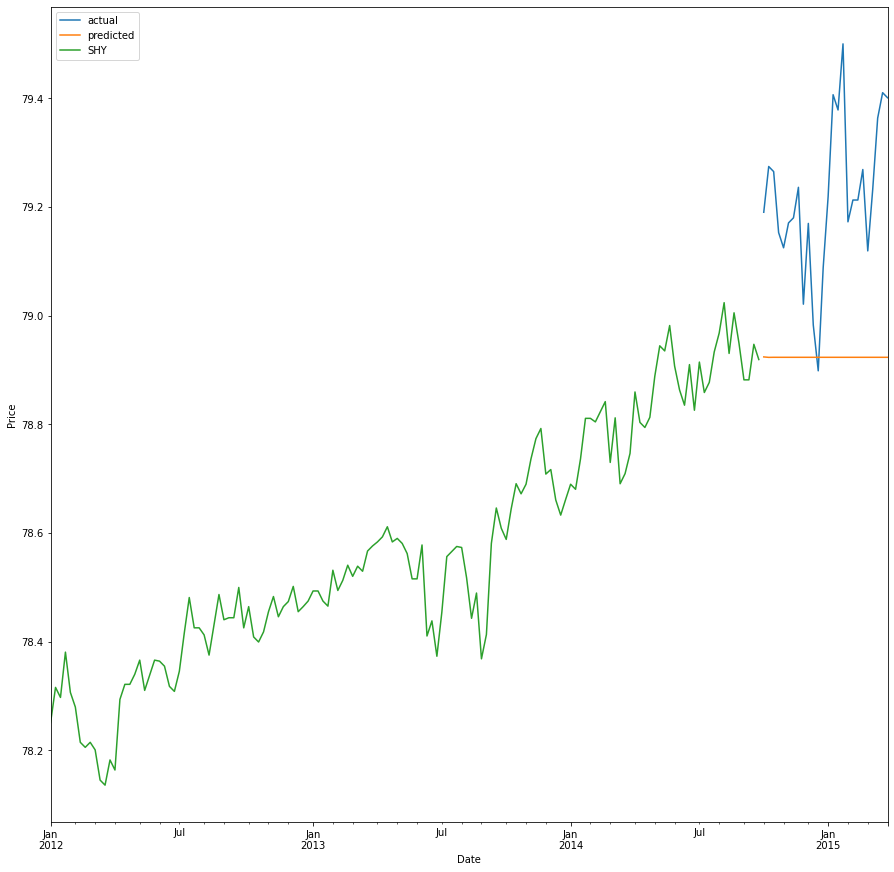

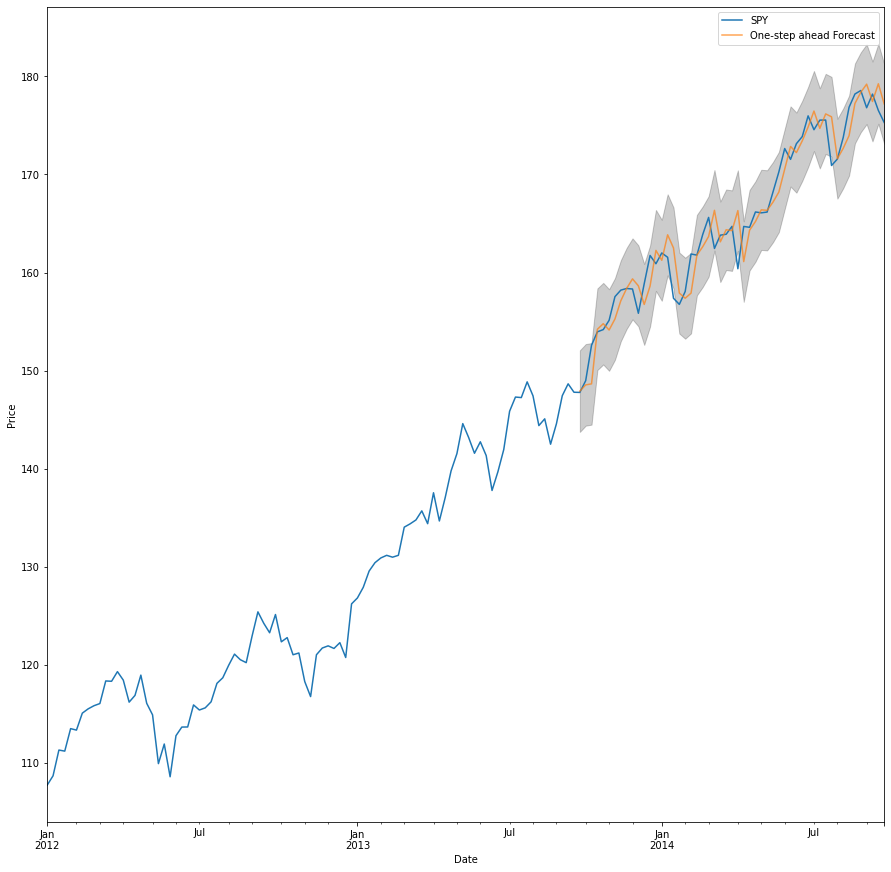

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.000   4403.031      0.000       1.000       1.001
sigma2         0.0299      0.002     16.434      0.000       0.026       0.033


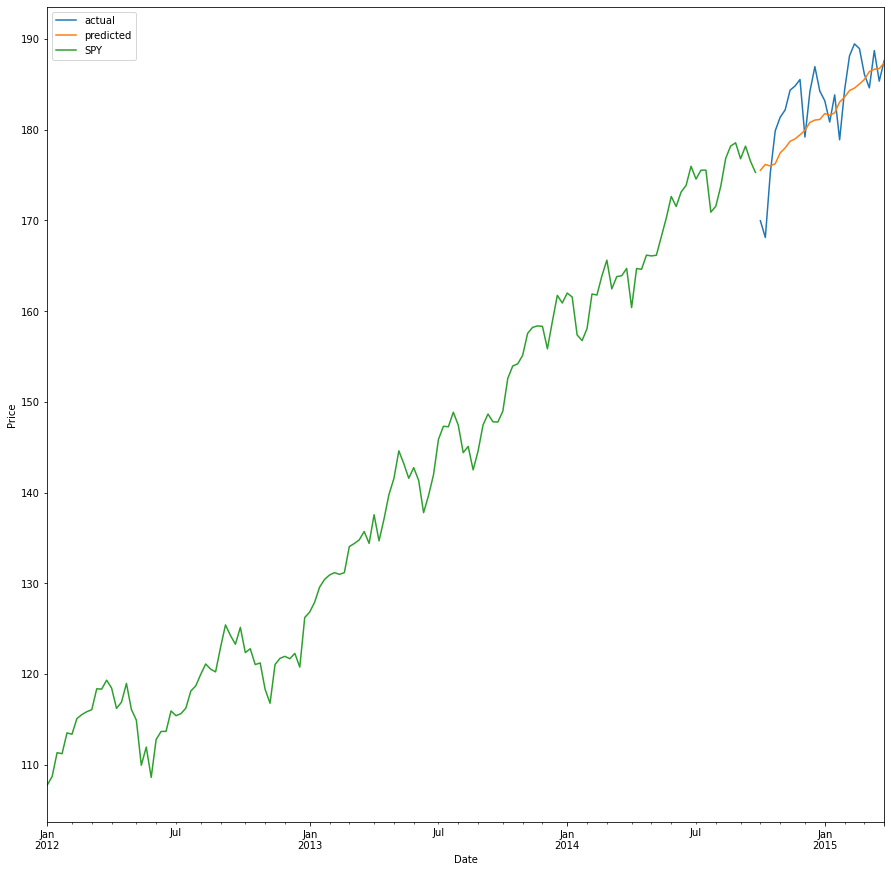

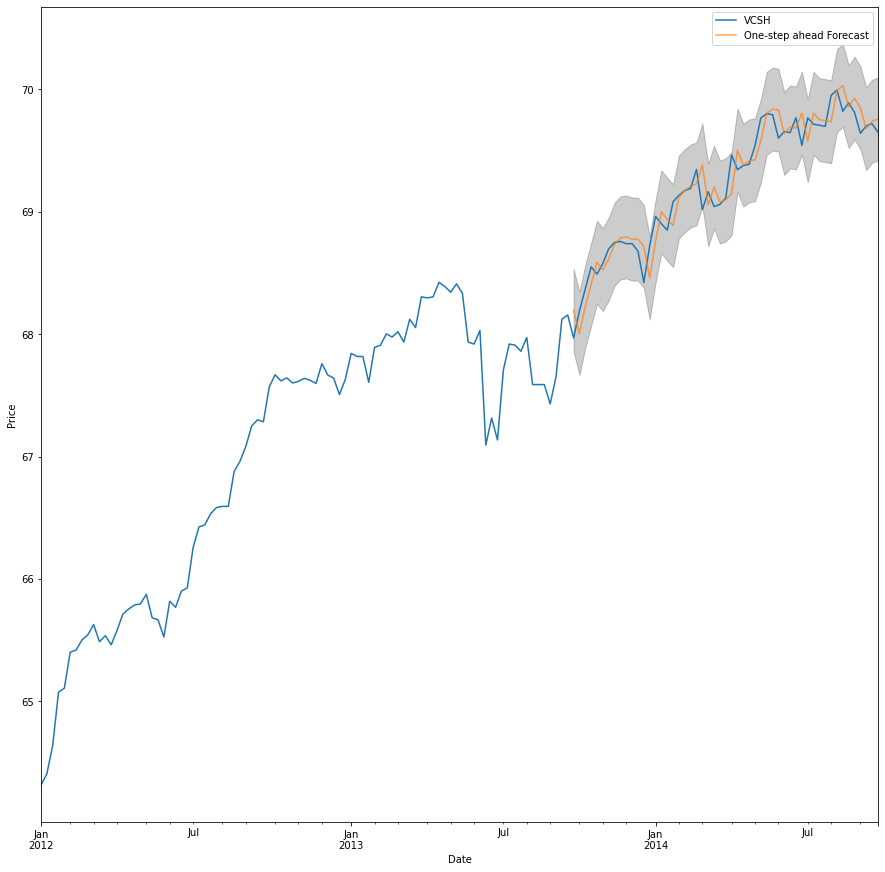

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0071      0.110     -0.065      0.948      -0.223       0.209
ma.S.L12      -0.9517      0.283     -3.357      0.001      -1.507      -0.396
sigma2         1.5930      0.349      4.561      0.000       0.908       2.278


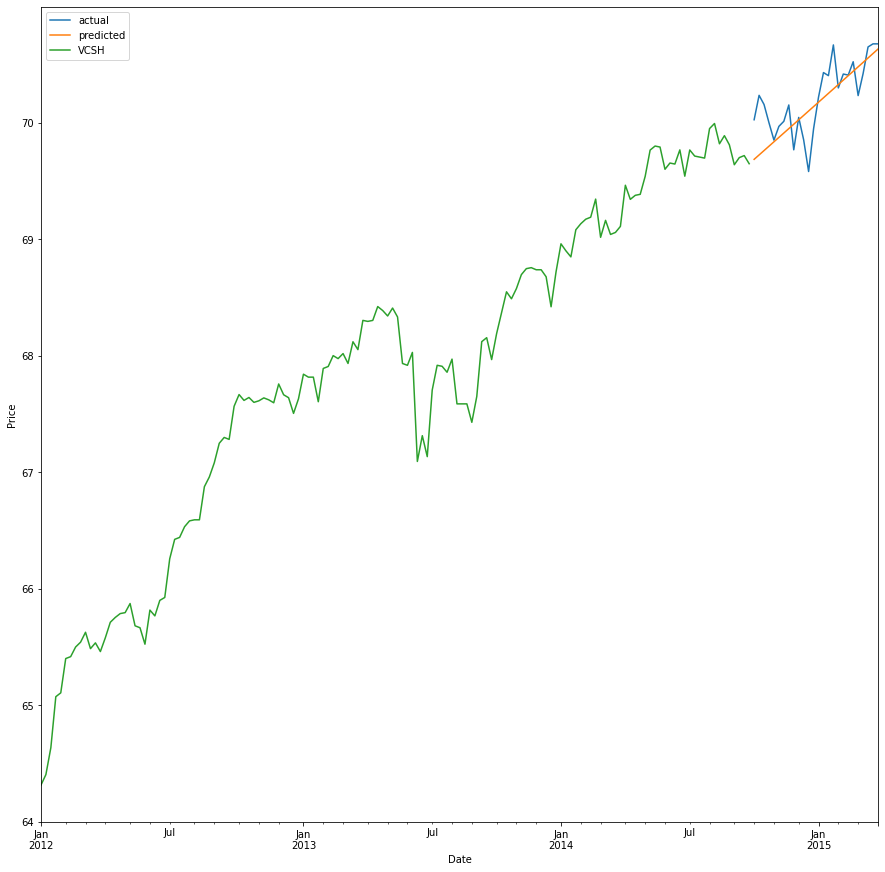

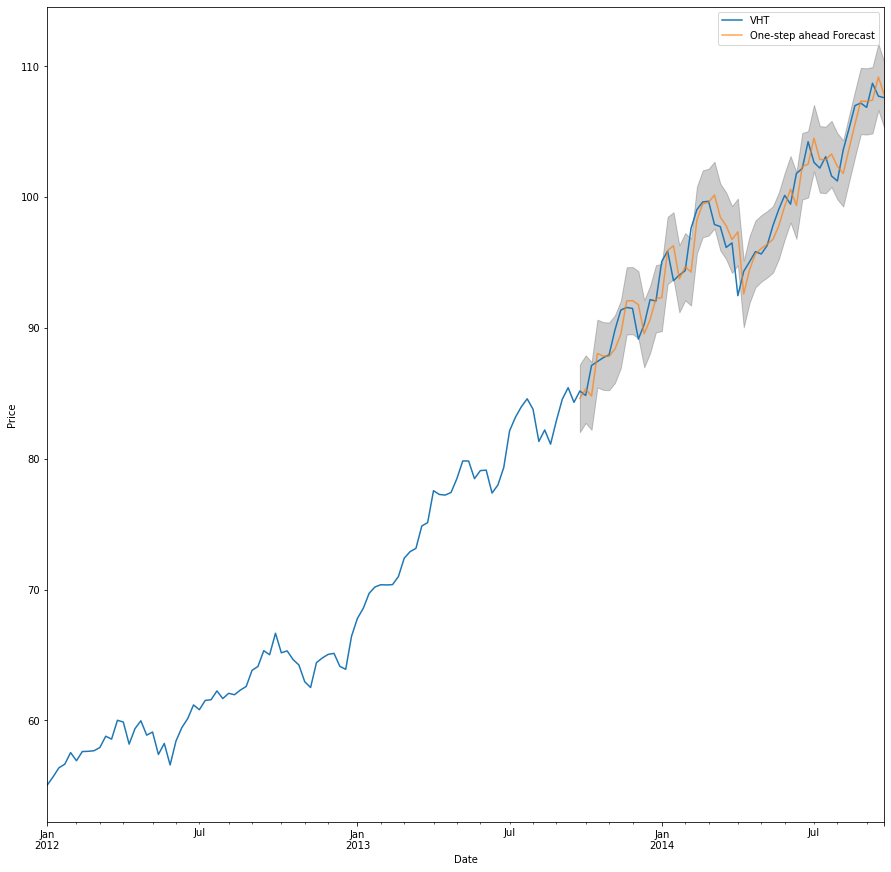

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0467      0.095     -0.490      0.624      -0.233       0.140
ma.S.L12      -1.0001    216.884     -0.005      0.996    -426.085     424.085
sigma2         1.1430    247.973      0.005      0.996    -484.875     487.162


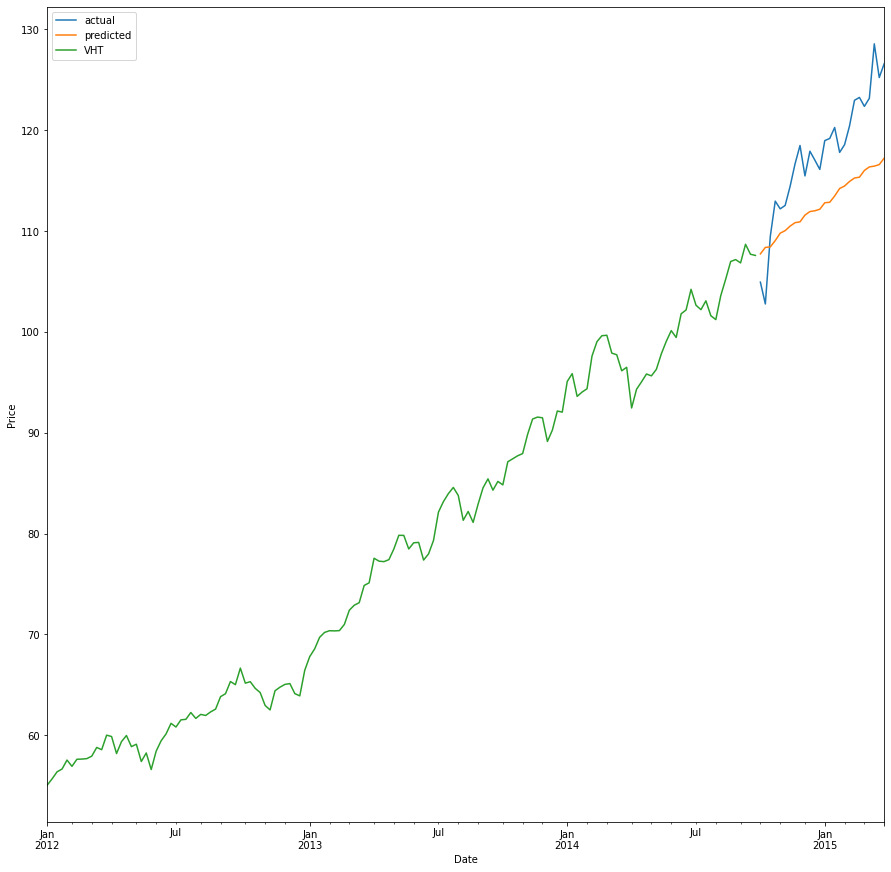

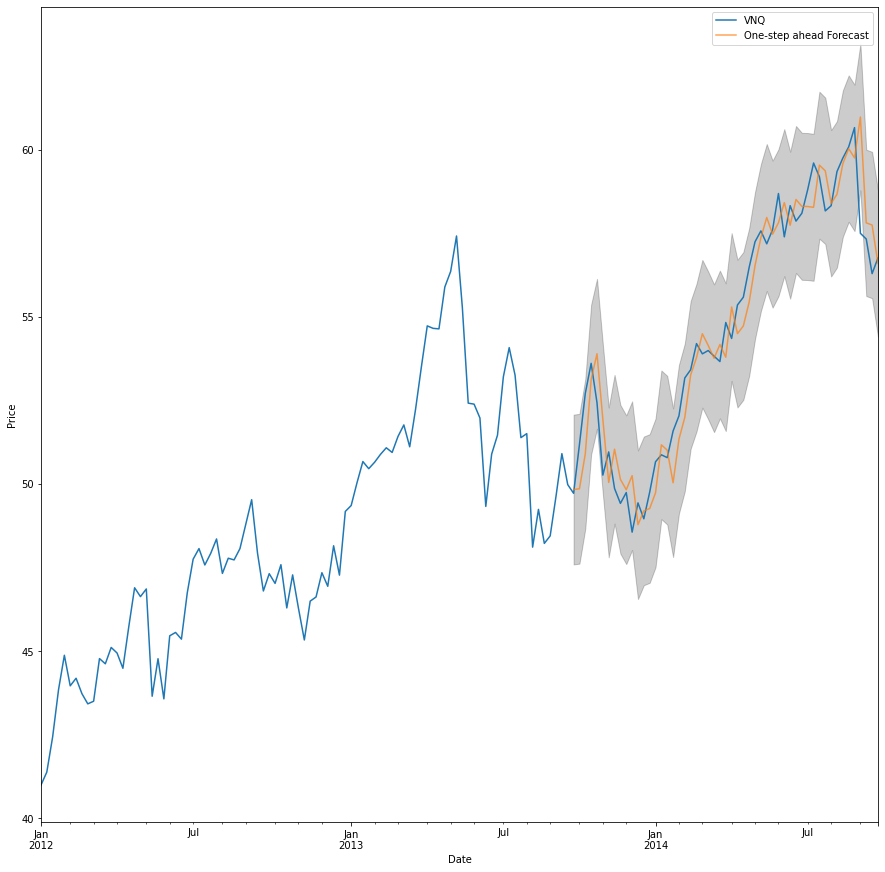

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9222      0.044    -20.736      0.000      -1.009      -0.835
ma.L1          1.0000    319.121      0.003      0.997    -624.466     626.466
ma.S.L12      -1.0001    213.565     -0.005      0.996    -419.580     417.579
sigma2         0.4188    153.192      0.003      0.998    -299.832     300.670


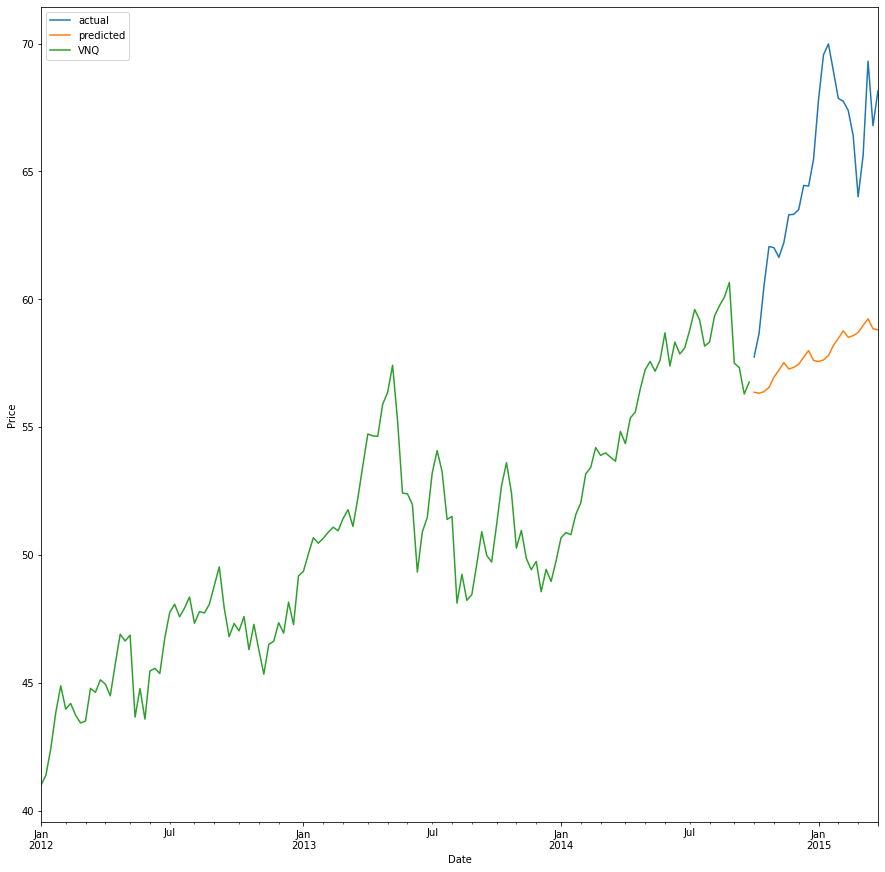

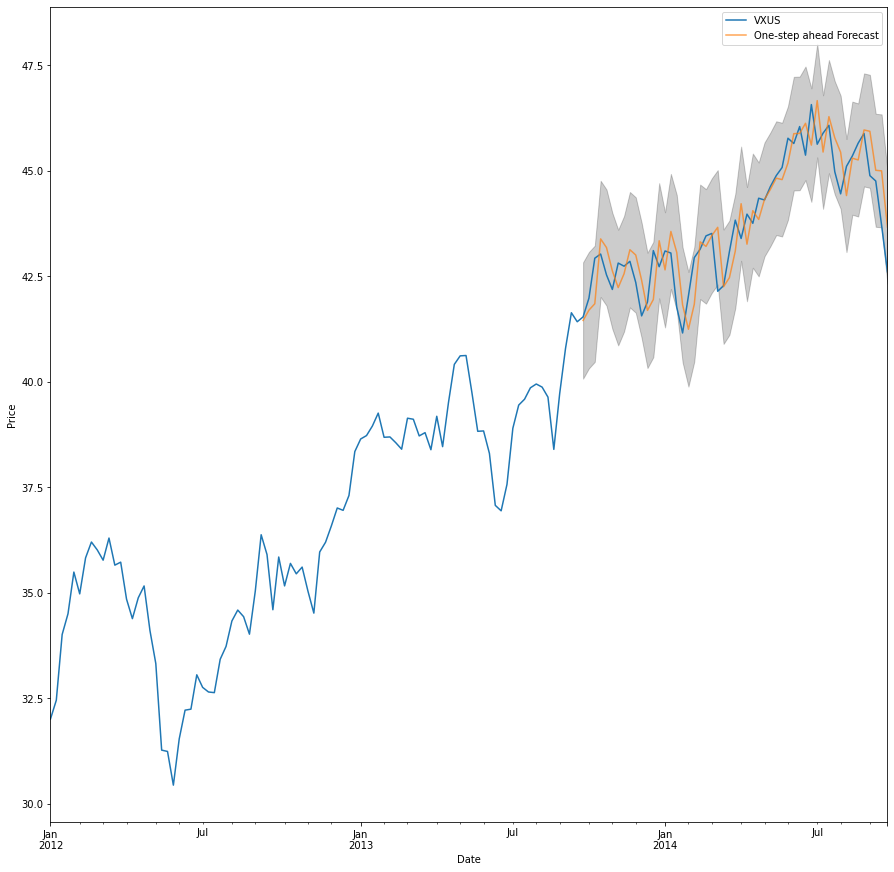

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.000   2819.413      0.000       1.000       1.001
ma.L1         -0.2525      0.095     -2.668      0.008      -0.438      -0.067
sigma2         0.0186      0.002     10.456      0.000       0.015       0.022


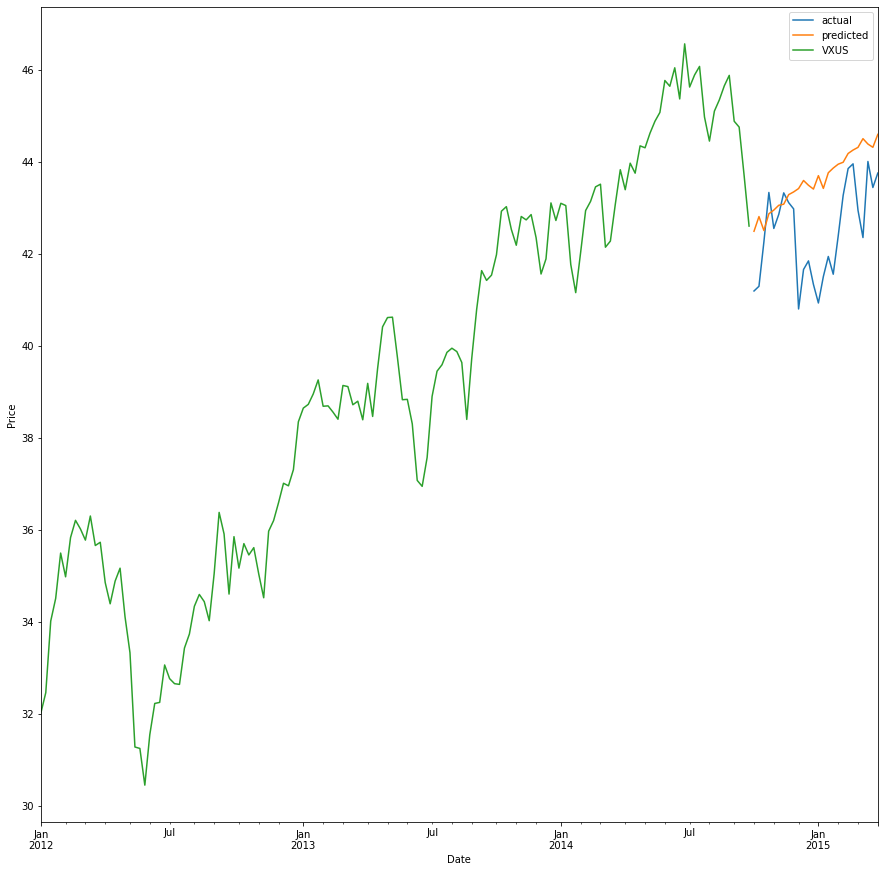

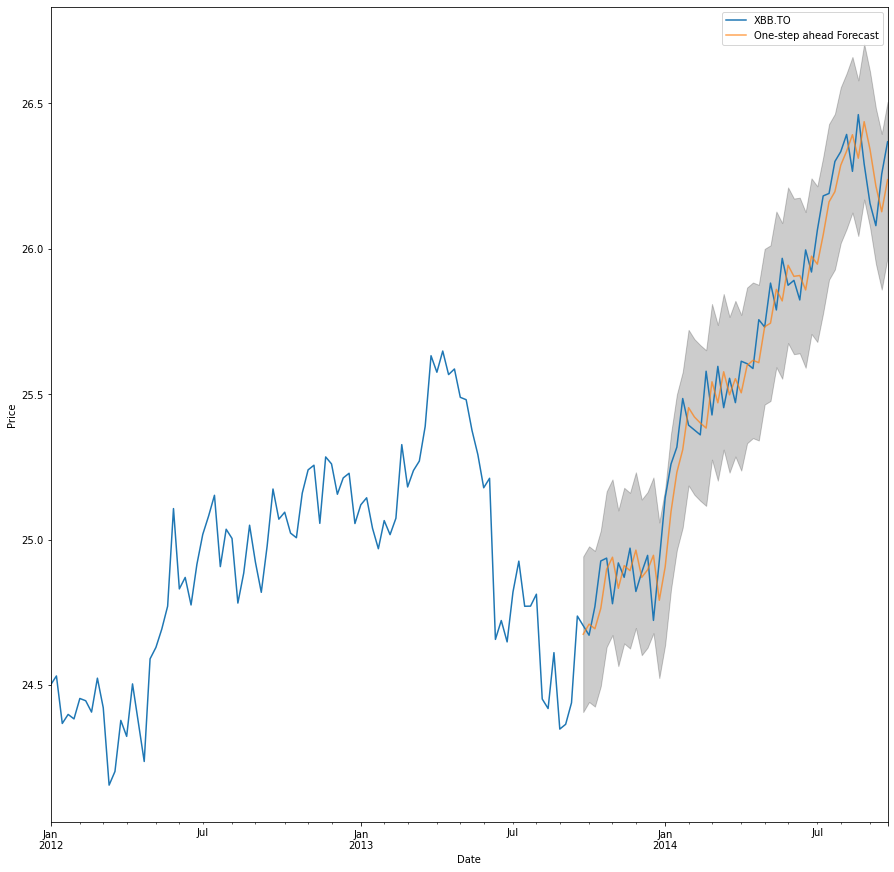

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0019      0.001    908.463      0.000       1.000       1.004
sigma2         0.0445      0.006      7.332      0.000       0.033       0.056


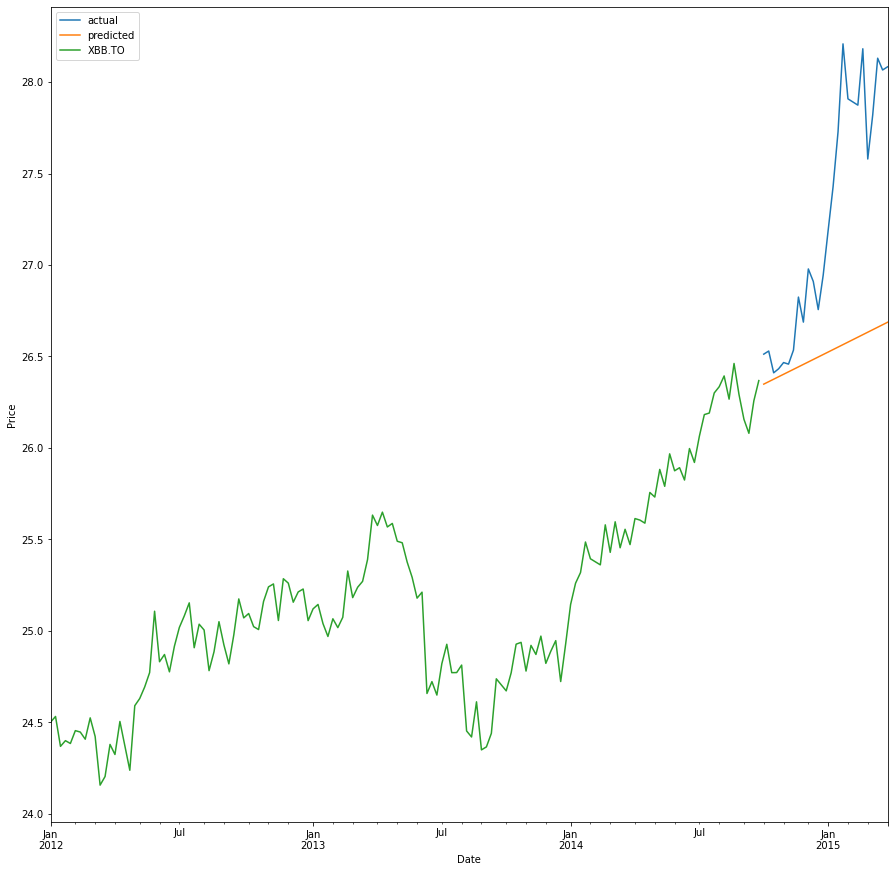

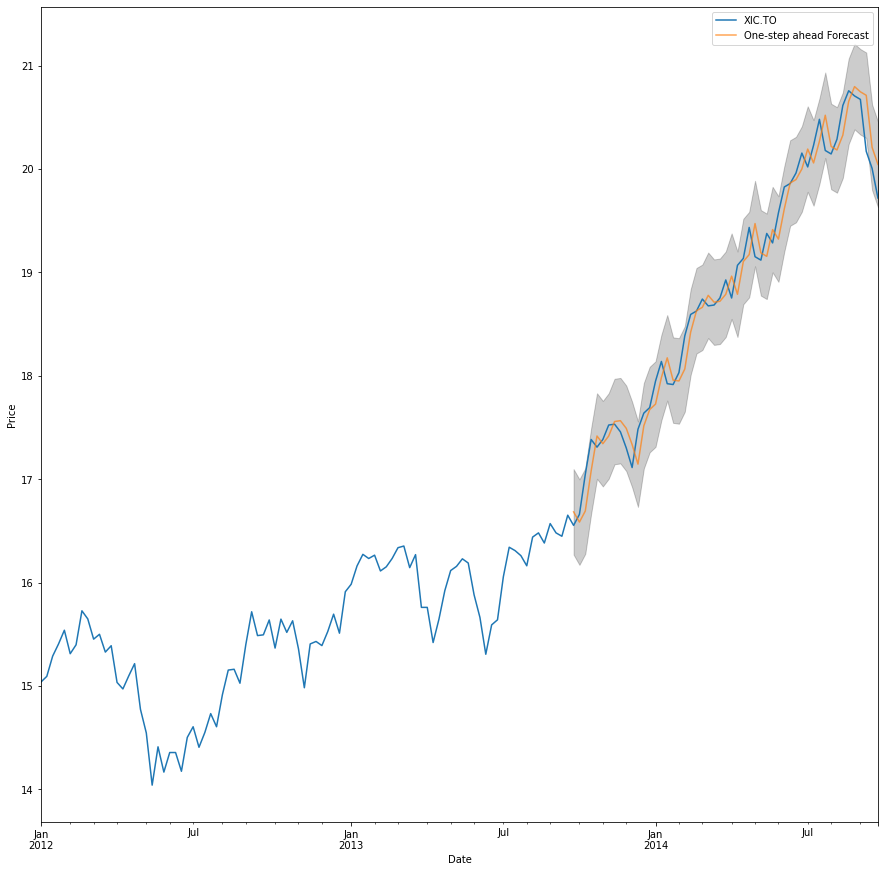

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0027      0.001    882.389      0.000       1.001       1.005
ma.S.L12      -0.1826      0.110     -1.659      0.097      -0.398       0.033
sigma2         0.1895      0.026      7.242      0.000       0.138       0.241


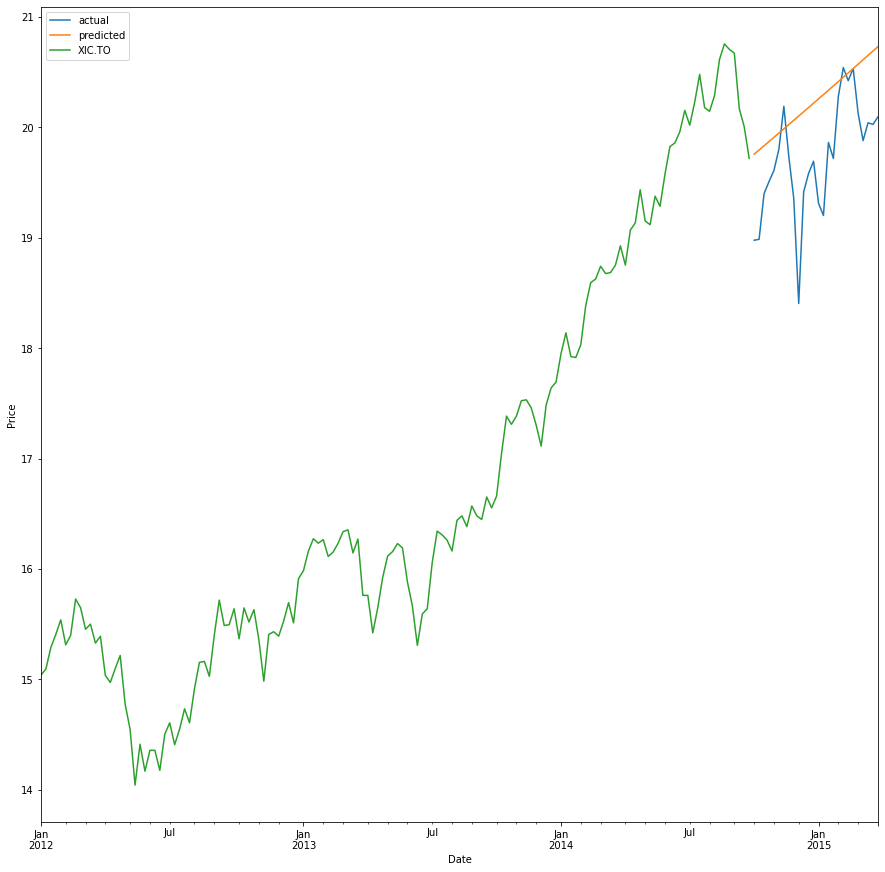

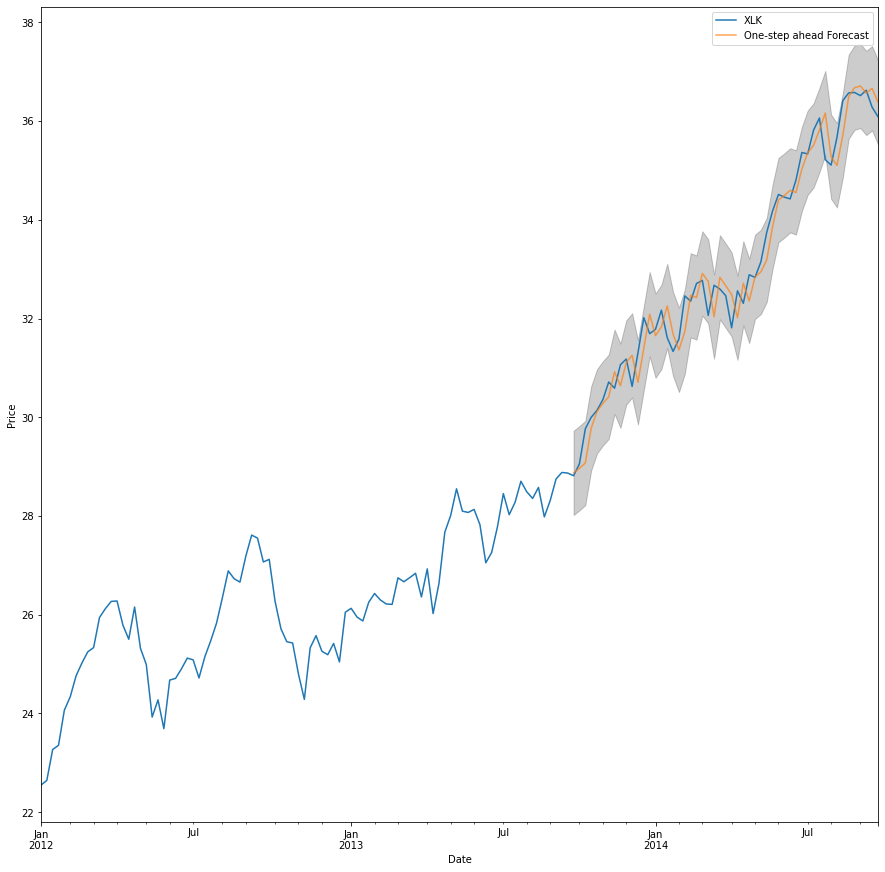

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0005      0.000   5851.591      0.000       1.000       1.001
ma.L1         -0.3257      0.085     -3.835      0.000      -0.492      -0.159
sigma2         0.0021      0.000      9.544      0.000       0.002       0.003


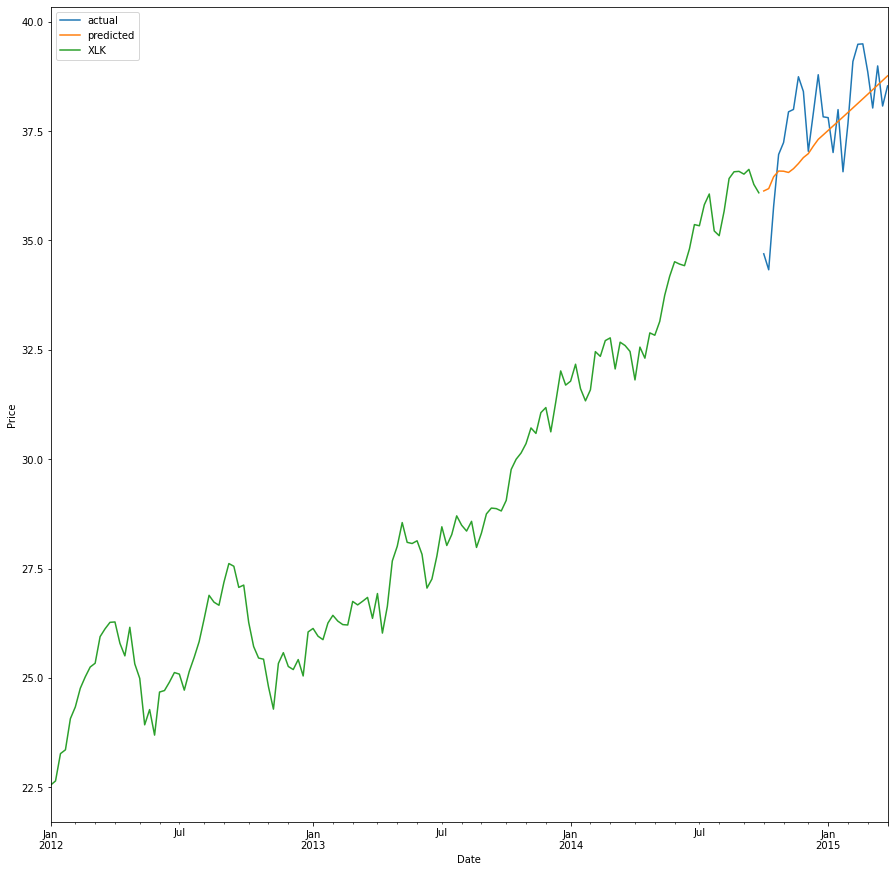

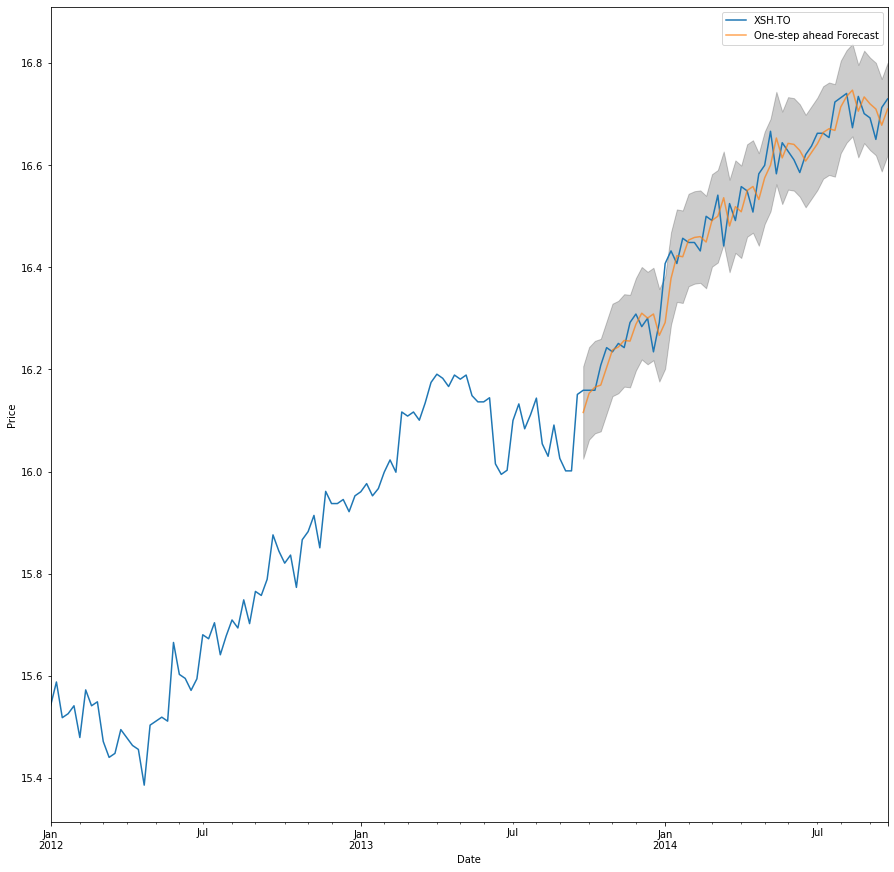

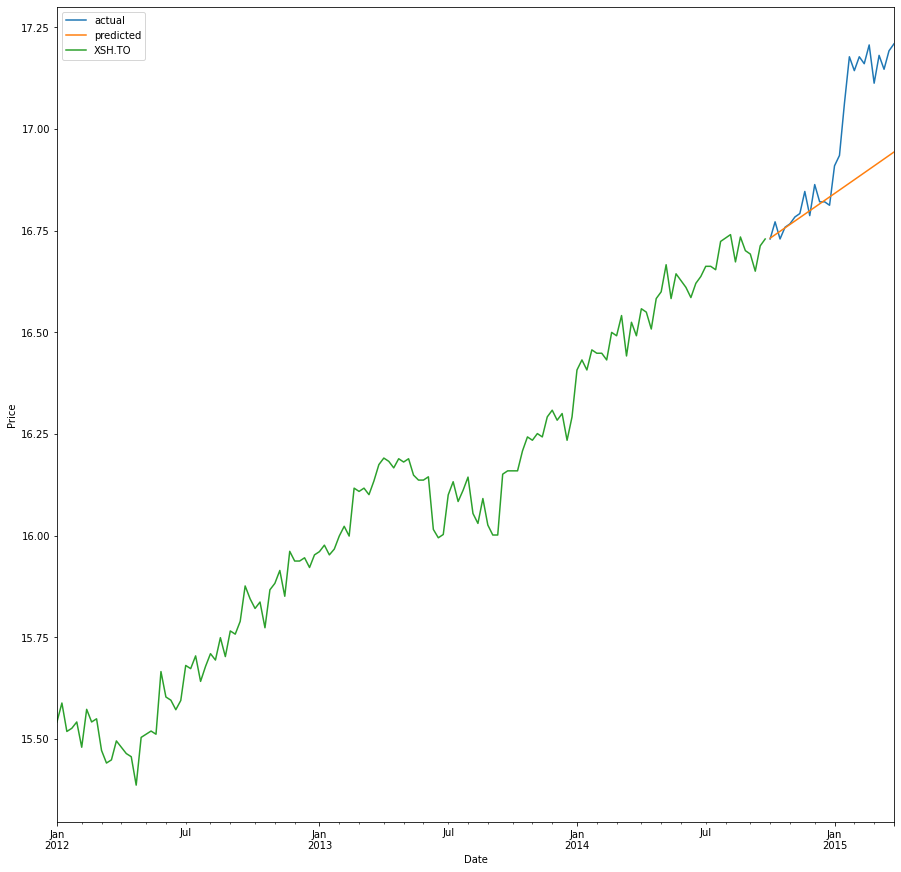

In [ ]:

for j in range(num_of_forcast):
  forcast_monthly_return = [0]*len(df.columns)
  # loop inside relablance

  invest_start_day = invest_end_day
  invest_end_day = invest_start_day + relativedelta(months=+6)
  # for last forcast period less than 6 months, use final day as last day

  if invest_end_day > final_day:
    invest_end_day = final_day
  
  end_day = invest_start_day - relativedelta(days=1)
  test_start_day = end_day - relativedelta(years=1)
  test = df[invest_start_day:invest_end_day]

  # for i in range(1):
  for i in range(len(df.columns)):
  # for model selection 
    series = df[:end_day]
    series = series.iloc[:,i].dropna()
    param_optimal, param_seasonal_optimal, aic = optimal_para_selection(series,i)
    results = evaluate_model(series,param_optimal, param_seasonal_optimal)
    print(results.summary().tables[1])
    evaluate_plot(series, results,test_start_day,plot_start_day) 

    # for rebalance
    # use all the historical data to train the model
    series_train = series #[test_start_day:end_day]

    train_result = train_model(series_train,param_optimal, param_seasonal_optimal)

    # test data frame adding the predicted value
    test = prediction(train_result,i)
    #  performance of first rebalancing 
    investment_plot(i,series_train,numOfETF)
    # calculate monthly return
    forcast_monthly_return[i] = test['pred'+str(i)].resample('M').ffill().pct_change().dropna().mean()
  forcast_monthly_return_table_bt[invest_end_day] = forcast_monthly_return
forcast_monthly_return_table_bt.to_csv("expected_return_validate.csv")